In [236]:
from pathlib import Path
import pandas as pd
import numpy as np

# -------- path helper (same as in 01GNDataPipeline) -------- #
def find_upwards(rel_path: Path, max_up: int = 8) -> Path:
    here = Path.cwd()
    for parent in [here, *here.parents][: max_up + 1]:
        candidate = (parent / rel_path)
        if candidate.exists():
            return candidate.resolve()
    raise FileNotFoundError(
        f"Couldn't locate '{rel_path.as_posix()}' from {here} by walking up {max_up} levels."
    )

# -------- files -------- #
DATA_DIR   = find_upwards(Path("GrossToNet/Data"))
DEALS_CSV  = DATA_DIR / "deal_cash_flow.csv"
FUNDS_CSV  = DATA_DIR / "fund_cash_flow.csv"
MAP_CSV    = DATA_DIR / "deal_to_fund.csv"  # optional

date_parser = lambda s: pd.to_datetime(s, format="%Y-%m-%d", errors="coerce")

# --- load cash flows (dates are yyyy-mm-dd) ---
deals = pd.read_csv(
    DEALS_CSV,
    dtype={"id": str, "deal_id": str},
)
funds = pd.read_csv(
    FUNDS_CSV,
    dtype={"id": str, "fund_id": str},
)

# parse dates explicitly (yyyy-mm-dd)
deals["cash_flow_date"] = pd.to_datetime(deals["cash_flow_date"], format="%Y-%m-%d", errors="coerce")
funds["cash_flow_date"] = pd.to_datetime(funds["cash_flow_date"], format="%Y-%m-%d", errors="coerce")

# standardize column names
deals = deals.rename(columns={"cash_flow_date": "date", "cash_flow": "amount"})
funds = funds.rename(columns={"cash_flow_date": "date", "cash_flow": "amount"})


# optional: deal→fund map (if present)
if MAP_CSV.exists():
    deal_to_fund = pd.read_csv(MAP_CSV, dtype={"deal_id": str, "fund_id": str})
else:
    deal_to_fund = pd.DataFrame(columns=["deal_id", "fund_id"])

# quick sanity checks
assert {"id", "deal_id", "amount", "date"}.issubset(deals.columns), deals.columns
assert {"id", "fund_id", "amount", "date"}.issubset(funds.columns), funds.columns


In [237]:
# ---------- Normalize types and enforce sign conventions ---------- #

# Pre-checks
req_f_cols = {"id", "fund_id", "amount", "date", "cash_flow_type"}
req_d_cols = {"id", "deal_id", "amount", "date", "cash_flow_type"}
assert req_f_cols.issubset(funds.columns), f"Missing in funds: {req_f_cols - set(funds.columns)}"
assert req_d_cols.issubset(deals.columns), f"Missing in deals: {req_d_cols - set(deals.columns)}"
assert pd.api.types.is_datetime64_any_dtype(funds["date"]), "funds.date must be datetime"
assert pd.api.types.is_datetime64_any_dtype(deals["date"]), "deals.date must be datetime"
assert funds["amount"].dtype.kind in "fi", "funds.amount must be numeric"
assert deals["amount"].dtype.kind in "fi", "deals.amount must be numeric"
assert funds["date"].notna().all(), "NaT in funds.date"
assert deals["date"].notna().all(), "NaT in deals.date"

# Canonicalize cash_flow_type
funds_map = {
    "contribution": "contribution",
    "distribution": "distribution",
    "nav": "nav",
}
deals_map = {
    "investment": "investment",
    "proceed": "proceed",
    "fair value": "fair_value",
}

funds["type_std"] = (
    funds["cash_flow_type"].astype(str).str.strip().str.lower().map(funds_map)
)
deals["type_std"] = (
    deals["cash_flow_type"].astype(str).str.strip().str.lower().map(deals_map)
)

# Validate types are known
unknown_f = funds[funds["type_std"].isna()]["cash_flow_type"].value_counts()
unknown_d = deals[deals["type_std"].isna()]["cash_flow_type"].value_counts()
assert unknown_f.empty, f"Unknown funds cash_flow_type: \n{unknown_f}"
assert unknown_d.empty, f"Unknown deals cash_flow_type: \n{unknown_d}"

# Enforce signs deterministically (use abs to avoid double flips)
# Funds: contribution negative; distribution/NAV non-negative
funds.loc[funds["type_std"] == "contribution", "amount"] = -funds.loc[
    funds["type_std"] == "contribution", "amount"
].abs()
funds.loc[funds["type_std"].isin(["distribution", "nav"]), "amount"] = funds.loc[
    funds["type_std"].isin(["distribution", "nav"]), "amount"
].abs()

# Deals: investment negative; proceed/fair_value non-negative
deals.loc[deals["type_std"] == "investment", "amount"] = -deals.loc[
    deals["type_std"] == "investment", "amount"
].abs()
deals.loc[deals["type_std"].isin(["proceed", "fair_value"]), "amount"] = deals.loc[
    deals["type_std"].isin(["proceed", "fair_value"]), "amount"
].abs()

#======= Only keep latest NAV/Fair Value snapshots to avoid double counting ========
# Funds: keep only last NAV per fund_id
nav = funds[funds.type_std=='nav']
keep_nav = nav.loc[nav.groupby('fund_id')['date'].idxmax()]
funds = pd.concat([funds[funds.type_std!='nav'], keep_nav], ignore_index=True)

# Deals: keep only last fair_value per deal_id
fv = deals[deals.type_std=='fair_value']
keep_fv = fv.loc[fv.groupby('deal_id')['date'].idxmax()]
deals = pd.concat([deals[deals.type_std!='fair_value'], keep_fv], ignore_index=True)
# ===================================================================================

# Post-conditions: strict sign checks
assert (funds.loc[funds["type_std"] == "contribution", "amount"] <= 0).all(), \
    "Found positive contribution amounts in funds."
assert (funds.loc[funds["type_std"].isin(["distribution", "nav"]), "amount"] >= 0).all(), \
    "Found negative distribution/NAV amounts in funds."

assert (deals.loc[deals["type_std"] == "investment", "amount"] <= 0).all(), \
    "Found positive investment amounts in deals."
assert (deals.loc[deals["type_std"].isin(["proceed", "fair_value"]), "amount"] >= 0).all(), \
    "Found negative proceed/fair_value amounts in deals."

# Quick summaries (useful for spot checks)
print("Funds types:\n", funds["type_std"].value_counts(dropna=False).to_string())
print("Deals types:\n", deals["type_std"].value_counts(dropna=False).to_string())
print(
    "Funds sign check:",
    {
        "contribution_min": float(funds.loc[funds.type_std=="contribution","amount"].min())
            if (funds.type_std=="contribution").any() else None,
        "dist_nav_min": float(funds.loc[funds.type_std.isin(["distribution","nav"]),"amount"].min())
            if (funds.type_std.isin(["distribution","nav"])).any() else None,
    }
)
print(
    "Deals sign check:",
    {
        "investment_min": float(deals.loc[deals.type_std=="investment","amount"].min())
            if (deals.type_std=="investment").any() else None,
        "proc_fv_min": float(deals.loc[deals.type_std.isin(["proceed","fair_value"]),"amount"].min())
            if (deals.type_std.isin(["proceed","fair_value"])).any() else None,
    }
)

print(funds.groupby('type_std')['amount'].sum())
print(deals.groupby('type_std')['amount'].sum())
print("Funds date range:", funds['date'].min(), funds['date'].max())
print("Deals date range:", deals['date'].min(), deals['date'].max())


Funds types:
 type_std
contribution    3455
distribution    1832
nav               83
Deals types:
 type_std
proceed       5780
investment    5521
fair_value     560
Funds sign check: {'contribution_min': -17352054794.5205, 'dist_nav_min': 5.551115123125779e-11}
Deals sign check: {'investment_min': -3285071667.0, 'proc_fv_min': 0.0}
type_std
contribution   -2.582624e+11
distribution    3.863123e+11
nav             1.408069e+11
Name: amount, dtype: float64
type_std
fair_value    1.486937e+11
investment   -1.805312e+11
proceed       1.747012e+11
Name: amount, dtype: float64
Funds date range: 1994-04-06 00:00:00 2025-06-30 00:00:00
Deals date range: 1992-07-02 00:00:00 2025-04-01 00:00:00


In [238]:
# =================== Currency conversion to USD ===================

from pathlib import Path
import pandas as pd
import numpy as np

# ---------- Locate & read monthly FX (Excel-serial dates; wide -> tidy) ----------
def find_upwards(rel_path: Path, max_up: int = 8) -> Path:
    here = Path.cwd()
    for parent in [here, *here.parents][: max_up + 1]:
        candidate = (parent / rel_path)
        if candidate.exists():
            return candidate.resolve()
    raise FileNotFoundError(f"Couldn't locate '{rel_path.as_posix()}' from {here} by walking up {max_up} levels.")

FX_WIDE_CSV = find_upwards(Path("InputData/currencies.csv"))
fx_wide = pd.read_csv(FX_WIDE_CSV)

# Validate minimal structure
assert "date" in fx_wide.columns, f"'date' column missing in {FX_WIDE_CSV}"
ccy_cols = [c for c in fx_wide.columns if c != "date"]
assert ccy_cols, "No currency columns found in currencies.csv (expected like USD, EUR, GBP, ...)."

# Convert Excel serial to datetime (assumed month-end values)
fx_wide["date"] = pd.to_datetime(pd.to_numeric(fx_wide["date"], errors="coerce"), unit="D",
                                 origin="1899-12-30", errors="coerce")
assert fx_wide["date"].notna().all(), "Failed to parse some FX dates from Excel serials."

# Melt to tidy; normalize currency codes; keep numeric
fx = (
    fx_wide.melt(id_vars="date", var_name="currency", value_name="fx_to_USD")
          .assign(currency=lambda d: d["currency"].astype(str).str.strip().str.upper())
)
# Coerce to numeric; drop fully empty rows
fx["fx_to_USD"] = pd.to_numeric(fx["fx_to_USD"], errors="coerce")
fx = fx.dropna(subset=["fx_to_USD"])

# Enforce uniqueness per (date,currency)
dup = fx.duplicated(subset=["date","currency"])
assert not dup.any(), f"Duplicate FX rows for same (date,currency). Examples:\n{fx.loc[dup, ['date','currency']].head()}"

# For monthly alignment: compute month-end for FX dates (defensive; should already be month-end)
fx["month_end"] = fx["date"] + pd.offsets.MonthEnd(0)
fx = fx[["month_end","currency","fx_to_USD"]].rename(columns={"month_end":"date_me"}).sort_values(["currency","date_me"])

# ---------- Prepare deals for FX join (align to month-end) ----------
# Requirements already ensured upstream: deals has ['date','amount','currency','deal_id'] and 'date' is datetime64
req_deal_cols = {"deal_id","date","amount","currency"}
assert req_deal_cols.issubset(deals.columns), f"Deals missing {req_deal_cols - set(deals.columns)}"
assert pd.api.types.is_datetime64_any_dtype(deals["date"]), "deals.date must be datetime"

deals["currency"] = deals["currency"].astype(str).str.strip().str.upper()
deals["date_me"] = deals["date"] + pd.offsets.MonthEnd(0)

# Left-join by nearest past (exact month match via key equality; if your FX is strictly one per month, direct merge is fine)
deals_fx = deals.merge(fx, left_on=["date_me","currency"], right_on=["date_me","currency"], how="left")

# Compute USD amount (USD column in FX is 1.0 ⇒ values are USD per unit of currency)
deals_fx["amount_usd"] = deals_fx["amount"] * deals_fx["fx_to_USD"]

# ---------- Prepare funds for FX join (via fund_currency) ----------
# If all funds are already USD, conversion is identity; otherwise join on fund_currency.
req_fund_cols = {"fund_id","date","amount"}
assert req_fund_cols.issubset(funds.columns), f"Funds missing {req_fund_cols - set(funds.columns)}"
assert pd.api.types.is_datetime64_any_dtype(funds["date"]), "funds.date must be datetime"

# Prefer previously added 'fund_currency' (from your enrichment step). If absent, fall back to a generic 'currency' if it exists.
fund_currency_col = "fund_currency" if "fund_currency" in funds.columns else ("currency" if "currency" in funds.columns else None)
assert fund_currency_col is not None, "Funds currency column not found (expected 'fund_currency' or 'currency')."

funds["date_me"] = funds["date"] + pd.offsets.MonthEnd(0)
funds[fund_currency_col] = funds[fund_currency_col].astype(str).str.strip().str.upper()

if (funds[fund_currency_col] == "USD").all():
    funds_fx = funds.copy()
    funds_fx["fx_to_USD"] = 1.0
    funds_fx["amount_usd"] = funds_fx["amount"]
else:
    funds_fx = funds.merge(
        fx.rename(columns={"currency":"fund_ccy"}),
        left_on=["date_me", fund_currency_col],
        right_on=["date_me", "fund_ccy"],
        how="left"
    )
    funds_fx["amount_usd"] = funds_fx["amount"] * funds_fx["fx_to_USD"]

# ---------- QA / Coverage Reporting ----------
def coverage_report(df, id_col, ccy_col_name):
    missing = df[df["fx_to_USD"].isna()]
    total_rows = len(df)
    missing_rows = len(missing)
    missing_groups = missing[id_col].nunique(dropna=False) if id_col in df.columns else np.nan
    # Identify cases where currency exists but its series starts later than the cash-flow date’s month
    # Heuristic: if currency has any FX rows at all, but for this date_me there is no match.
    has_series = df[ccy_col_name].map(df[ccy_col_name].dropna().unique().__contains__)
    # (Above is always True; better check in FX table:)
    ccy_has_fx = df[ccy_col_name].isin(fx["currency"].unique())
    late_start = missing[ccy_col_name].isin(fx["currency"].unique())

    print(f"[FX] {id_col}: {missing_groups} group(s) with at least one row missing FX; "
          f"row coverage {total_rows - missing_rows}/{total_rows} "
          f"({(total_rows - missing_rows)/total_rows:.1%}).")
    if not missing.empty:
        samp = missing[[id_col, ccy_col_name, "date_me"]].head(10)
        print(f"[FX] Sample missing ({id_col}, {ccy_col_name}, date_me):")
        print(samp.to_string(index=False))
        # Optional: show first available FX date per missing currency to indicate late starts
        first_fx = fx.groupby("currency")["date_me"].min()
        joined = (
            missing[[ccy_col_name]].assign(first_fx=lambda d: d[ccy_col_name].map(first_fx))
            .drop_duplicates()
            .sort_values(ccy_col_name)
            .head(10)
        )
        print("[FX] First available FX date per missing currency (sample):")
        print(joined.to_string(index=False))

# Deals coverage
coverage_report(deals_fx, id_col="deal_id", ccy_col_name="currency")

# Funds coverage
coverage_report(funds_fx, id_col="fund_id", ccy_col_name=(fund_currency_col if fund_currency_col in funds_fx.columns else "currency"))

# ---------- Persist back (optional) ----------
# If you want to overwrite your CSVs with USD amounts appended:
DATA_DIR = find_upwards(Path("GrossToNet/Data"))
DEALS_CSV = DATA_DIR / "deal_cash_flow.csv"
FUNDS_CSV = DATA_DIR / "fund_cash_flow.csv"

# Keep original columns + new FX outputs, preserve order
deal_cols_order = list(deals.columns) + [c for c in ["fx_to_USD","amount_usd"] if c not in deals.columns]
fund_cols_order = list(funds.columns) + [c for c in ["fx_to_USD","amount_usd"] if c not in funds.columns]

deals_out = deals_fx[deal_cols_order]
funds_out = funds_fx[fund_cols_order]

deals_out.to_csv(DEALS_CSV, index=False)
funds_out.to_csv(FUNDS_CSV, index=False)

print(f"[FX] Wrote USD amounts to:\n- {DEALS_CSV}\n- {FUNDS_CSV}")

# ---------- Sanity assertions ----------
# USD rows must have fx_to_USD == 1 within tolerance
usd_deals = deals_fx["currency"] == "USD"
if usd_deals.any():
    assert np.isfinite(deals_fx.loc[usd_deals, "fx_to_USD"]).all(), "Missing USD FX on USD rows."
    assert (deals_fx.loc[usd_deals, "fx_to_USD"].round(6) == 1.0).all(), "USD rate not equal to 1.0 for USD rows."
usd_funds = (funds_fx.get("fund_ccy", funds_fx.get(fund_currency_col)) == "USD")
if usd_funds.any():
    assert np.isfinite(funds_fx.loc[usd_funds, "fx_to_USD"]).all(), "Missing USD FX on USD funds."
    assert (funds_fx.loc[usd_funds, "fx_to_USD"].round(6) == 1.0).all(), "USD rate not equal to 1.0 for USD funds."

# No NaT introduced; amount_usd finite where fx exists
assert deals_fx["date_me"].notna().all() and funds_fx["date_me"].notna().all(), "NaT in month-end alignment."
assert np.isfinite(deals_fx.loc[deals_fx["fx_to_USD"].notna(), "amount_usd"]).all(), "Non-finite USD in deals."
assert np.isfinite(funds_fx.loc[funds_fx["fx_to_USD"].notna(), "amount_usd"]).all(), "Non-finite USD in funds."

# Drop entire deal_id groups with missing FX
invalid_fx_deal_ids = (
    deals_fx.groupby("deal_id")["fx_to_USD"]
            .apply(lambda s: s.isna().any())
            .pipe(lambda s: s[s].index.tolist())
)

before_rows  = len(deals_fx)
before_groups = deals_fx["deal_id"].nunique()

deals_fx = deals_fx[~deals_fx["deal_id"].isin(invalid_fx_deal_ids)].copy()

after_rows   = len(deals_fx)
after_groups = deals_fx["deal_id"].nunique()

print(f"[FX-CLEAN] Removed {len(invalid_fx_deal_ids)} deal_id groups due to missing FX "
      f"({before_groups} -> {after_groups}); rows {before_rows} -> {after_rows}.")
if invalid_fx_deal_ids:
    print("Sample removed deal_ids:", invalid_fx_deal_ids[:10])

# (Optional) persist
DATA_DIR = find_upwards(Path("GrossToNet/Data"))
DEALS_CSV = DATA_DIR / "deal_cash_flow.csv"

# Keep prior column order + fx_to_USD, amount_usd
deal_cols_order = [c for c in deals.columns] + [c for c in ["fx_to_USD","amount_usd","date_me"] if c not in deals.columns]
deals_out = deals_fx[deal_cols_order]
deals_out.to_csv(DEALS_CSV, index=False)
print(f"[FX-CLEAN] Wrote cleaned deals to {DEALS_CSV}")


[FX] deal_id: 26 group(s) with at least one row missing FX; row coverage 11655/11861 (98.3%).
[FX] Sample missing (deal_id, currency, date_me):
                             deal_id currency    date_me
040365f7-7efc-492e-ac74-847cfcb5e94a      SEK 1999-06-30
040365f7-7efc-492e-ac74-847cfcb5e94a      SEK 1999-12-31
040365f7-7efc-492e-ac74-847cfcb5e94a      SEK 1999-12-31
040365f7-7efc-492e-ac74-847cfcb5e94a      SEK 2001-09-30
040365f7-7efc-492e-ac74-847cfcb5e94a      SEK 2002-03-31
040365f7-7efc-492e-ac74-847cfcb5e94a      SEK 2002-06-30
040365f7-7efc-492e-ac74-847cfcb5e94a      SEK 2002-08-31
040365f7-7efc-492e-ac74-847cfcb5e94a      SEK 2002-09-30
040365f7-7efc-492e-ac74-847cfcb5e94a      SEK 2003-09-30
040365f7-7efc-492e-ac74-847cfcb5e94a      SEK 2003-09-30
[FX] First available FX date per missing currency (sample):
currency   first_fx
     SEK 2005-02-28
[FX] fund_id: 0 group(s) with at least one row missing FX; row coverage 5370/5370 (100.0%).
[FX] Wrote USD amounts to:
- /Users/m

In [239]:
# ================== Benchmark construction ==================

from pathlib import Path
import pandas as pd
import numpy as np

# ---------- helpers ----------
def find_upwards(rel_path: Path, max_up: int = 8) -> Path:
    here = Path.cwd()
    for parent in [here, *here.parents][: max_up + 1]:
        candidate = (parent / rel_path)
        if candidate.exists():
            return candidate.resolve()
    raise FileNotFoundError(f"Couldn't locate '{rel_path.as_posix()}' from {here} by walking up {max_up} levels.")

def excel_serial_to_dt(s):
    ser = pd.to_numeric(s, errors="coerce")
    return pd.to_datetime(ser, unit="D", origin="1899-12-30", errors="coerce")

def first_value_on_or_after(s: pd.Series, t: pd.Timestamp):
    s2 = s[s.index >= t]
    if s2.empty:
        return np.nan
    return float(s2.iloc[0])

# ---------- FX (monthly, tidy; USD per 1 unit of currency) ----------
FX_WIDE_CSV = find_upwards(Path("InputData/currencies.csv"))
fx_wide = pd.read_csv(FX_WIDE_CSV)
assert "date" in fx_wide.columns, "FX: missing date"
fx_wide["date"] = excel_serial_to_dt(fx_wide["date"]).dt.to_period("M").dt.to_timestamp("M")

fx = (
    fx_wide.melt(id_vars="date", var_name="currency", value_name="fx_to_USD")
          .assign(currency=lambda d: d["currency"].astype(str).str.upper().str.strip())
)
fx["fx_to_USD"] = pd.to_numeric(fx["fx_to_USD"], errors="coerce")
fx = fx.dropna(subset=["fx_to_USD"])
fx = fx.rename(columns={"date":"date_me"})[["date_me","currency","fx_to_USD"]]
assert not fx.duplicated(["date_me","currency"]).any(), "FX: duplicate (date,currency)"

# Ensure USD rows exist and equal 1.0 (fill if missing)
usd_me = fx.loc[fx["currency"]=="USD","date_me"].unique()
if len(usd_me) == 0:
    usd_me = fx["date_me"].unique()
fx_usd_fill = pd.DataFrame({"date_me": usd_me, "currency":"USD", "fx_to_USD":1.0})
fx = pd.concat([fx, fx_usd_fill]).drop_duplicates(["date_me","currency"], keep="first")

# ---------- indices (weekly) ----------
IDX_CSV = find_upwards(Path("InputData/indices.csv"))
idx_wide = pd.read_csv(IDX_CSV)
assert {"date","S&P500","FTSE100","DAX40"}.issubset(idx_wide.columns), "indices: expected columns missing"

idx_wide["date"] = excel_serial_to_dt(idx_wide["date"])
assert idx_wide["date"].notna().all(), "indices: bad dates"
idx_wide = idx_wide.sort_values("date").set_index("date")

# ---------- FX attach that preserves the original weekly DatetimeIndex ----------
def to_usd(series: pd.Series, ccy: str) -> pd.Series:
    # Preserve the DatetimeIndex
    df = series.to_frame("value").copy()
    df["date_me"] = df.index.to_period("M").to_timestamp("M")
    if ccy == "USD":
        df["fx_to_USD"] = 1.0
    else:
        fx_ccy = (
            fx.loc[fx["currency"] == ccy, ["date_me", "fx_to_USD"]]
              .set_index("date_me")["fx_to_USD"]
        )
        df["fx_to_USD"] = df["date_me"].map(fx_ccy)
    miss = int(df["fx_to_USD"].isna().sum())
    if miss:
        first_fx = fx.loc[fx["currency"]==ccy,"date_me"].min()
        print(f"[IDX→USD] {series.name}: dropped {miss} rows due to missing {ccy}/USD FX. First {ccy} FX at {first_fx}.")
    out = (df["value"] * df["fx_to_USD"]).dropna()
    out.index = df.index[df["fx_to_USD"].notna()]  # keep original weekly dates
    return out

sp500_usd = to_usd(idx_wide["S&P500"].astype(float), "USD").rename("S&P500_USD")
ftse_usd  = to_usd(idx_wide["FTSE100"].astype(float), "GBP").rename("FTSE100_USD")
dax_usd   = to_usd(idx_wide["DAX40"].astype(float),   "EUR").rename("DAX40_USD")

# ---------- strict date overlap across the three USD series ----------
sp_idx  = sp500_usd.index
ft_idx  = ftse_usd.index
dx_idx  = dax_usd.index
common = sp_idx.intersection(ft_idx).intersection(dx_idx).sort_values()

if len(common) == 0:
    print("[DIAG] S&P500_USD range:", sp500_usd.index.min(), "→", sp500_usd.index.max(), "rows:", len(sp500_usd))
    print("[DIAG] FTSE100_USD range:", ftse_usd.index.min(),  "→", ftse_usd.index.max(),  "rows:", len(ftse_usd))
    print("[DIAG] DAX40_USD range:",  dax_usd.index.min(),   "→", dax_usd.index.max(),   "rows:", len(dax_usd))
    only_sp = sp_idx.difference(ft_idx.union(dx_idx))
    only_ft = ft_idx.difference(sp_idx.union(dx_idx))
    only_dx = dx_idx.difference(sp_idx.union(ft_idx))
    print("[DIAG] Dates only in S&P500 (sample):", list(only_sp[:5]))
    print("[DIAG] Dates only in FTSE100 (sample):", list(only_ft[:5]))
    print("[DIAG] Dates only in DAX40 (sample):",  list(only_dx[:5]))
    raise ValueError("No common dates across all three USD series after FX conversion.")

idx_usd = pd.DataFrame({
    "S&P500_USD":  sp500_usd.reindex(common),
    "FTSE100_USD": ftse_usd.reindex(common),
    "DAX40_USD":   dax_usd.reindex(common),
}, index=common)

# ---------- weights ----------
USE_DATA_WEIGHTS = True            # toggle
HARDCODE_WEIGHTS = {"EUR":0.30, "USD":0.60, "GBP":0.10}

if USE_DATA_WEIGHTS:
    req = {"currency","amount","date"}
    assert req.issubset(deals.columns), f"deals missing {req - set(deals.columns)}"
    deals["currency"] = deals["currency"].astype(str).str.upper().str.strip()
    inv = deals.loc[deals["amount"] < 0].copy()
    inv["abs_amt"] = inv["amount"].abs()
    by_ccy = inv.groupby("currency")["abs_amt"].sum()
    by_ccy = by_ccy.reindex(["EUR","USD","GBP"]).dropna()
    if by_ccy.empty:
        print("[WEIGHTS] No investment data for EUR/USD/GBP; falling back to hardcoded.")
        weights = HARDCODE_WEIGHTS.copy()
    else:
        weights = (by_ccy / by_ccy.sum()).to_dict()
else:
    weights = HARDCODE_WEIGHTS.copy()

w = pd.Series(weights).reindex(["EUR","USD","GBP"]).fillna(0.0)
if w.sum() == 0:
    raise ValueError("Weights sum to zero.")
w = w / w.sum()
print("[WEIGHTS] Using:", {k: round(float(v),4) for k,v in w.items()})

# ---------- normalization base (use overlapped dates, not raw start_cf) ----------
start_cf = min(deals["date"].min(), funds["date"].min())

comp_first = idx_usd.index.min()
comp_last  = idx_usd.index.max()

ix = idx_usd.index[idx_usd.index >= start_cf]
base_date = ix[0] if len(ix) else comp_first
if len(ix) == 0:
    print(f"[COMPOSITE] start_cf {start_cf.date()} < earliest overlap {comp_first.date()}; using base_date={base_date.date()}.")

base_vals = idx_usd.loc[base_date]
if base_vals.isna().any():
    raise ValueError(f"Base date {base_date.date()} has NaNs in overlapped series: {base_vals.to_dict()}")

sp500_n = (idx_usd["S&P500_USD"]  / base_vals["S&P500_USD"]).rename("S&P500_N")
ftse_n  = (idx_usd["FTSE100_USD"] / base_vals["FTSE100_USD"]).rename("FTSE100_N")
dax_n   = (idx_usd["DAX40_USD"]   / base_vals["DAX40_USD"]).rename("DAX40_N")

# ---------- composite (USD) ----------
comp = (w["USD"]*sp500_n + w["GBP"]*ftse_n + w["EUR"]*dax_n).rename("composite_usd")
print(f"[COMPOSITE] Base date: {base_date.date()} | overlap: {comp_first.date()} → {comp_last.date()}")

# ---------- persist ----------
DATA_DIR = find_upwards(Path("GrossToNet/Data"))
OUT_CSV  = DATA_DIR / "composite_index_usd.csv"
pd.DataFrame({"date": comp.index, "composite_usd": comp.values}).to_csv(OUT_CSV, index=False)
print(f"[COMPOSITE] Wrote {len(comp):,} rows to {OUT_CSV}")

# Optional sanity
print("[COMPOSITE] Range:", float(comp.min()), "→", float(comp.max()))


[IDX→USD] FTSE100: dropped 1 rows due to missing GBP/USD FX. First GBP FX at 1976-01-31 00:00:00.
[IDX→USD] DAX40: dropped 1 rows due to missing EUR/USD FX. First EUR FX at 1976-01-31 00:00:00.
[WEIGHTS] Using: {'EUR': 0.1982, 'USD': 0.7367, 'GBP': 0.0651}
[COMPOSITE] Base date: 1992-07-06 | overlap: 1992-04-06 → 2025-09-29
[COMPOSITE] Wrote 1,748 rows to /Users/michael/Library/Mobile Documents/com~apple~CloudDocs/Studium TUM/Master Management and Technology/06 Master Thesis/00 Thesis/05Code/GrossToNet/Data/composite_index_usd.csv
[COMPOSITE] Range: 0.9151651509454514 → 25.504840179992218


In [240]:
# ================ KS-PME engine ===================

from __future__ import annotations
from pathlib import Path
import pandas as pd
import numpy as np

# ---------------------- helpers ----------------------

def find_upwards(rel_path: Path, max_up: int = 8) -> Path:
    here = Path.cwd()
    for parent in [here, *here.parents][: max_up + 1]:
        candidate = (parent / rel_path)
        if candidate.exists():
            return candidate.resolve()
    raise FileNotFoundError(
        f"Couldn't locate '{rel_path.as_posix()}' from {here} by walking up {max_up} levels."
    )

def _as_ts_index(x: pd.Series) -> pd.Series:
    """Return a copy with a tz-naive, monotonic DatetimeIndex; values must be non-NA."""
    assert isinstance(x, pd.Series), "index_series must be a pandas Series."
    idx = pd.to_datetime(x.index, errors="coerce")
    assert idx.tz is None, "Index must be tz-naive."
    out = x.copy()
    out.index = idx
    out = out.sort_index()
    assert out.index.is_monotonic_increasing, "Index must be monotonic increasing."
    assert out.notna().all(), "Index series contains NaNs."
    return out

def _assert_index_valid(idx: pd.Series) -> None:
    """Values must be finite and strictly positive."""
    v = idx.to_numpy(dtype=float, copy=False)
    assert np.isfinite(v).all(), "Index contains NaN/inf."
    assert (v > 0).all(), "Index contains non-positive values."

def _pick_amount_col(df: pd.DataFrame) -> str:
    if "amount_usd" in df.columns:
        return "amount_usd"
    if "amount" in df.columns:
        return "amount"
    raise KeyError("Neither 'amount_usd' nor 'amount' present in cashflows_df.")

def load_composite_usd_series() -> pd.Series:
    """Load USD composite index as Series(date -> level), deduped/sorted/validated."""
    data_dir = find_upwards(Path("GrossToNet/Data"))
    comp_path = data_dir / "composite_index_usd.csv"
    comp_df = pd.read_csv(comp_path, parse_dates=["date"])
    comp_df = comp_df.drop_duplicates("date").sort_values("date")
    s = pd.Series(comp_df["composite_usd"].astype(float).values,
                  index=pd.to_datetime(comp_df["date"], errors="coerce"),
                  name="composite_usd")
    s = _as_ts_index(s)
    _assert_index_valid(s)
    return s

def _ensure_tznaive(s: pd.Series, date_col: str) -> None:
    if not pd.api.types.is_datetime64_any_dtype(s[date_col]):
        s[date_col] = pd.to_datetime(s[date_col], errors="coerce")
    assert s[date_col].dt.tz is None, f"{date_col} must be tz-naive."

def aggregate_same_day(cf: pd.DataFrame, date_col: str, amt_col: str) -> pd.DataFrame:
    """Collapse multiple CFs occurring on the same calendar day."""
    cf = cf[[date_col, amt_col]].copy()
    cf[date_col] = pd.to_datetime(cf[date_col], errors="coerce")
    cf = cf.dropna(subset=[date_col, amt_col])
    cf = (cf.groupby(date_col, as_index=False)[amt_col]
            .sum()
            .sort_values(date_col))
    return cf

def clip_to_index_end(cf: pd.DataFrame, idx: pd.Series, date_col: str, amt_col: str) -> pd.DataFrame:
    """
    Move each flow strictly after the last index date to the last index date (preserves signs).
    Then re-aggregate by date.
    """
    last_idx = idx.index.max()
    cf = cf[[date_col, amt_col]].copy()
    cf[date_col] = pd.to_datetime(cf[date_col], errors="coerce")
    mask = cf[date_col] > last_idx
    if mask.any():
        cf.loc[mask, date_col] = last_idx
    return aggregate_same_day(cf, date_col, amt_col)

# ---------------------- shared preprocessing ----------------------

def _prep_cf_and_index(
    cashflows_df: pd.DataFrame,
    index_series: pd.Series,
    amount_col: str,
    date_col: str = "date",
) -> tuple[pd.DataFrame, np.ndarray]:
    """
    Returns (aggregated_cf, aligned_index_values_for_cf_rows).
    - Forces datetime, tz-naive.
    - Aggregates same-day flows.
    - Clips flows after last index date (moving each to last date).
    - Aligns via backward merge_asof.
    """
    cf = cashflows_df[[date_col, amount_col]].copy()
    _ensure_tznaive(cf, date_col)
    cf = aggregate_same_day(cf, date_col, amount_col)

    idx = _as_ts_index(index_series.rename("I"))
    _assert_index_valid(idx)

    # Guard: CFs must not start before index
    cf_min = cf[date_col].min()
    idx_min = idx.index.min()
    if cf_min < idx_min:
        raise ValueError(
            f"Cash-flow date {cf_min.date()} precedes index start {idx_min.date()}. "
            f"Clip flows or extend the index."
        )

    # Clip tail flows to last index date preserving signs
    cf = clip_to_index_end(cf, idx, date_col, amount_col)

    # Backward align on/before CF date; ensure both sides sorted on key
    idx_df = idx.reset_index().rename(columns={"index": "date"}).sort_values("date")
    cf_sorted = cf.sort_values(date_col)
    aligned = pd.merge_asof(
        cf_sorted[[date_col]],
        idx_df,
        left_on=date_col,
        right_on="date",
        direction="backward",
        allow_exact_matches=True,
    )["I"].to_numpy(dtype=float)

    if not np.isfinite(aligned).all():
        bad_dates = cf_sorted.loc[~np.isfinite(aligned), date_col].dt.date.tolist()[:5]
        raise ValueError(f"Missing/invalid index values for CF dates: {bad_dates}")

    if not (aligned > 0).all():
        bad_dates = cf_sorted.loc[aligned <= 0, date_col].dt.date.tolist()[:5]
        raise ValueError(f"Non-positive index values on aligned CF dates: {bad_dates}")

    return cf_sorted, aligned

# ---------------------- KS-PME engine ----------------------

def ks_pme_ratio(
    cashflows_df: pd.DataFrame,
    index_series: pd.Series,
    amount_col: str | None = None,
    date_col: str = "date",
) -> float:
    """
    Kaplan & Schoar PME ratio:
      PME = (Σ_t distributions_t / I_t) / (Σ_t contributions_t / I_t)
    Expected signs: + for distributions/NAV/FV, − for contributions/investments.
    The index is assumed to be USD; amounts must be USD.
    """
    if amount_col is None:
        amount_col = _pick_amount_col(cashflows_df)
    if amount_col != "amount_usd":
        raise AssertionError("PME index is USD; cash-flow amounts must be in 'amount_usd'.")

    cf_sorted, I = _prep_cf_and_index(cashflows_df, index_series, amount_col, date_col)

    shares = (cf_sorted[amount_col].to_numpy(dtype=float) / I).astype(float)
    contrib = float((-shares[shares < 0]).sum())
    dist    = float(( shares[shares > 0]).sum())
    return dist / contrib if contrib > 1e-12 else np.nan

def pme_components(
    cashflows_df: pd.DataFrame,
    index_series: pd.Series,
    amount_col: str | None = None,
    date_col: str = "date",
) -> tuple[float, float]:
    """
    Returns (numerator, denominator) = (Σ dist/I, Σ contrib/I),
    using the exact same preprocessing as ks_pme_ratio.
    """
    if amount_col is None:
        amount_col = _pick_amount_col(cashflows_df)
    if amount_col != "amount_usd":
        raise AssertionError("PME index is USD; cash-flow amounts must be in 'amount_usd'.")

    cf_sorted, I = _prep_cf_and_index(cashflows_df, index_series, amount_col, date_col)
    shares = (cf_sorted[amount_col].to_numpy(dtype=float) / I).astype(float)
    num = float(( shares[shares > 0]).sum())
    den = float((-shares[shares < 0]).sum())
    return num, den

# ---------------------- Wrappers ----------------------

def _normalize_type_col(df: pd.DataFrame) -> tuple[pd.DataFrame, str]:
    """Prefer canonical 'type_std'; else lower-case 'cash_flow_type'."""
    df = df.copy()
    if "type_std" in df.columns:
        type_col = "type_std"
    else:
        type_col = "cash_flow_type"
        df[type_col] = df[type_col].astype(str).str.strip().str.lower()
    return df, type_col

def ks_pme_for_fund(
    funds_df: pd.DataFrame,
    fund_id: str,
    index_series: pd.Series | None = None,
    include_nav: bool = True,
    date_col: str = "date",
) -> float:
    if index_series is None:
        index_series = load_composite_usd_series()
    f, type_col = _normalize_type_col(funds_df)

    keep = {"contribution", "distribution"}
    if include_nav:
        keep.add("nav")

    if date_col not in f.columns and "cash_flow_date" in f.columns:
        f = f.rename(columns={"cash_flow_date": date_col})

    f = f[(f.get("fund_id").astype(str) == str(fund_id)) & (f[type_col].isin(keep))]
    if f.empty:
        return np.nan

    amt_col = _pick_amount_col(f)
    if amt_col != "amount_usd":
        raise AssertionError("Fund PME requires USD amounts (amount_usd).")

    return ks_pme_ratio(f[[date_col, amt_col]], index_series, amount_col=amt_col, date_col=date_col)

def ks_pme_all_funds(
    funds_df: pd.DataFrame,
    index_series: pd.Series | None = None,
    include_nav: bool = True,
    date_col: str = "date",
) -> pd.Series:
    if index_series is None:
        index_series = load_composite_usd_series()
    f, type_col = _normalize_type_col(funds_df)

    keep = {"contribution", "distribution"}
    if include_nav:
        keep.add("nav")

    if date_col not in f.columns and "cash_flow_date" in f.columns:
        f = f.rename(columns={"cash_flow_date": date_col})

    amt_col = _pick_amount_col(f)
    if amt_col != "amount_usd":
        raise AssertionError("Fund PME requires USD amounts (amount_usd).")

    out: dict[str, float] = {}
    for fid, g in f[f[type_col].isin(keep)].groupby("fund_id", dropna=False):
        out[fid] = ks_pme_ratio(g[[date_col, amt_col]], index_series, amount_col=amt_col, date_col=date_col)
    return pd.Series(out, name="net_pme")

def ks_pme_for_deals(
    deals_df: pd.DataFrame,
    index_series: pd.Series | None = None,
    include_fair_value: bool = True,
    date_col: str = "date",
) -> float:
    if index_series is None:
        index_series = load_composite_usd_series()
    d, type_col = _normalize_type_col(deals_df)

    keep = {"investment", "proceed"}
    if include_fair_value:
        keep.add("fair_value")

    if date_col not in d.columns and "cash_flow_date" in d.columns:
        d = d.rename(columns={"cash_flow_date": date_col})

    d = d[d[type_col].isin(keep)]
    if d.empty:
        return np.nan

    amt_col = _pick_amount_col(d)
    if amt_col != "amount_usd":
        raise AssertionError("Deal PME requires USD amounts (amount_usd).")

    return ks_pme_ratio(d[[date_col, amt_col]], index_series, amount_col=amt_col, date_col=date_col)

# ---------------------- Vintage analytics ----------------------

def _entity_vintage(
    df: pd.DataFrame,
    entity_col: str,
    type_col: str,
    neg_types: set[str],
    date_col: str,
) -> pd.Series:
    """
    Vintage year per entity = year of first negative cash-flow type (investment/contribution).
    Entities without such flows get NaN.
    """
    x = df[df[type_col].isin(neg_types)][[entity_col, date_col]].copy()
    x[date_col] = pd.to_datetime(x[date_col], errors="coerce")
    vint = x.groupby(entity_col, dropna=False)[date_col].min().dt.year
    return vint

def vintage_pme_deals(
    deals_df: pd.DataFrame,
    index_series: pd.Series,
    include_fair_value: bool = True,
    date_col: str = "date",
) -> pd.Series:
    d, type_col = _normalize_type_col(deals_df)
    if date_col not in d.columns and "cash_flow_date" in d.columns:
        d = d.rename(columns={"cash_flow_date": date_col})

    vint_map = _entity_vintage(d, "deal_id", type_col, {"investment"}, date_col)
    d = d.merge(vint_map.rename("vintage"), left_on="deal_id", right_index=True, how="left")

    keep = {"investment", "proceed"}
    if include_fair_value:
        keep.add("fair_value")
    d = d[d[type_col].isin(keep)]

    amt_col = _pick_amount_col(d)
    if amt_col != "amount_usd":
        raise AssertionError("Vintage PME (deals) requires USD amounts (amount_usd).")

    out: dict[int, float] = {}
    for yr, g in d.groupby("vintage", dropna=True):
        if pd.isna(yr):
            continue
        out[int(yr)] = ks_pme_ratio(g[[date_col, amt_col]], index_series, amount_col=amt_col, date_col=date_col)
    return pd.Series(out, name="gross_pme_by_vintage").sort_index()

def vintage_pme_funds(
    funds_df: pd.DataFrame,
    index_series: pd.Series,
    include_nav: bool = True,
    date_col: str = "date",
) -> pd.Series:
    f, type_col = _normalize_type_col(funds_df)
    if date_col not in f.columns and "cash_flow_date" in f.columns:
        f = f.rename(columns={"cash_flow_date": date_col})

    vint_map = _entity_vintage(f, "fund_id", type_col, {"contribution"}, date_col)
    f = f.merge(vint_map.rename("vintage"), left_on="fund_id", right_index=True, how="left")

    keep = {"contribution", "distribution"}
    if include_nav:
        keep.add("nav")
    f = f[f[type_col].isin(keep)]

    amt_col = _pick_amount_col(f)
    if amt_col != "amount_usd":
        raise AssertionError("Vintage PME (funds) requires USD amounts (amount_usd).")

    out: dict[int, float] = {}
    for yr, g in f.groupby("vintage", dropna=True):
        if pd.isna(yr):
            continue
        out[int(yr)] = ks_pme_ratio(g[[date_col, amt_col]], index_series, amount_col=amt_col, date_col=date_col)
    return pd.Series(out, name="net_pme_by_vintage").sort_index()


In [241]:
#================== Pooled PME output ==============

# 0) Load composite
# just before using comp / ks_pme_*
DATA_DIR = find_upwards(Path("GrossToNet/Data"))
deals = pd.read_csv(DATA_DIR / "deal_cash_flow.csv", parse_dates=["date"])
funds  = pd.read_csv(DATA_DIR / "fund_cash_flow.csv", parse_dates=["date"])

# hard assertions so you fail early if something’s off
for name, df in [("deals", deals), ("funds", funds)]:
    assert "amount_usd" in df.columns, f"{name}: missing amount_usd; run FX step or reload the enriched CSVs."
    assert np.isfinite(pd.to_numeric(df["amount_usd"], errors="coerce")).all(), f"{name}: non-finite amount_usd."

comp = load_composite_usd_series()

def _amt_col(df):  # convenience
    return "amount_usd" if "amount_usd" in df.columns else "amount"

# ---------- Assertions to avoid silent currency/index mismatch ----------
assert _amt_col(deals) == "amount_usd", "Deals must be USD-converted for a USD index."
assert _amt_col(funds) == "amount_usd", "Funds must be USD-converted for a USD index."

# 1) ----- GROSS PME (deals) -----
# Keep only investment/proceed/fair_value
type_col_d = "type_std" if "type_std" in deals.columns else "cash_flow_type"
deals_t = deals.copy()
if type_col_d == "cash_flow_type":
    deals_t[type_col_d] = deals_t[type_col_d].astype(str).str.strip().str.lower()

keep_d = {"investment", "proceed", "fair_value"}
deals_cf = deals_t.loc[deals_t[type_col_d].isin(keep_d), ["date", "amount_usd"]].dropna()

gross_pme = ks_pme_ratio(deals_cf, comp, amount_col="amount_usd", date_col="date")
g_num, g_den = pme_components(deals_cf, comp, amount_col="amount_usd", date_col="date")

# 2) ----- NET PME (funds) -----
type_col_f = "type_std" if "type_std" in funds.columns else "cash_flow_type"
funds_t = funds.copy()
if type_col_f == "cash_flow_type":
    funds_t[type_col_f] = funds_t[type_col_f].astype(str).str.strip().str.lower()

keep_f = {"contribution", "distribution", "nav"}
funds_cf = funds_t.loc[funds_t[type_col_f].isin(keep_f), ["date", "amount_usd"]].dropna()

net_pme = ks_pme_ratio(funds_cf, comp, amount_col="amount_usd", date_col="date")
n_num, n_den = pme_components(funds_cf, comp, amount_col="amount_usd", date_col="date")

fee_drag = gross_pme - net_pme

print("=== POOLED PME (USD composite) ===")
print(f"GROSS PME (deals)  : {gross_pme:0.4f} | Σdist/I={g_num:0.3f}, Σcontrib/I={g_den:0.3f}")
print(f"NET   PME (funds)  : {net_pme:0.4f} | Σdist/I={n_num:0.3f}, Σcontrib/I={n_den:0.3f}")
print(f"FEE DRAG (Δ PME)   : {fee_drag:0.4f}")

# 3) ----- Per-fund NET PME (include NAV) -----
net_pme_by_fund = ks_pme_all_funds(funds, comp, include_nav=True, date_col="date")
print("\n=== NET PME by Fund (head) ===")
print(net_pme_by_fund.dropna().sort_values(ascending=False).head(10).to_string())

# Optional summary stats
print("\n[NET PME per fund] count=", net_pme_by_fund.notna().sum(),
      " median=", round(float(net_pme_by_fund.median()), 3),
      " p25=", round(float(net_pme_by_fund.quantile(0.25)), 3),
      " p75=", round(float(net_pme_by_fund.quantile(0.75)), 3))

# 4) ----- Vintage PMEs -----
gross_by_vintage = vintage_pme_deals(deals, comp, include_fair_value=True, date_col="date")
net_by_vintage   = vintage_pme_funds(funds, comp, include_nav=True, date_col="date")

print("\n=== Gross PME by Deal Vintage (head) ===")
print(gross_by_vintage.head(10).to_string())

print("\n=== Net PME by Fund Vintage (head) ===")
print(net_by_vintage.head(10).to_string())

eps=1e-12
fund_den = {}
for fid,g in funds_t[funds_t[type_col_f].isin(keep_f)].groupby("fund_id"):
    num, den = pme_components(g[["date","amount_usd"]], comp, amount_col="amount_usd", date_col="date")
    if den>eps: fund_den[fid]=den
cw_net = float((net_pme_by_fund.dropna()*pd.Series(fund_den)).sum()/pd.Series(fund_den).sum())
assert np.isfinite(cw_net)
print("[RECON] Contribution-weighted mean PME (funds):", round(cw_net,6))

gross_real = ks_pme_ratio(deals_t.loc[deals_t[type_col_d].isin({"investment","proceed"}), ["date","amount_usd"]],
                          comp, amount_col="amount_usd")
net_real   = ks_pme_ratio(funds_t.loc[funds_t[type_col_f].isin({"contribution","distribution"}), ["date","amount_usd"]],
                          comp, amount_col="amount_usd")
print("[SENS] Gross realized-only PME:", round(gross_real,6), " | Δ vs gross:", round(gross_pme-gross_real,6))
print("[SENS] Net   realized-only PME:", round(net_real,6),   " | Δ vs net  :", round(net_pme-net_real,6))


# 5) ----- QA & integrity checks -----
print("\n=== QA ===")
print("Composite index range:", comp.index.min().date(), "→", comp.index.max().date())

# For pooled identities we want day-collapsed & clipped forms just for reporting
from copy import deepcopy
deals_cf_rep = aggregate_same_day(deepcopy(deals_cf), "date", "amount_usd")
deals_cf_rep = clip_to_index_end(deals_cf_rep, comp, "date", "amount_usd")
funds_cf_rep = aggregate_same_day(deepcopy(funds_cf), "date", "amount_usd")
funds_cf_rep = clip_to_index_end(funds_cf_rep, comp, "date", "amount_usd")

print("Deals CF range       :", pd.to_datetime(deals_cf_rep['date']).min().date(), "→", pd.to_datetime(deals_cf_rep['date']).max().date())
print("Funds CF range       :", pd.to_datetime(funds_cf_rep['date']).min().date(), "→", pd.to_datetime(funds_cf_rep['date']).max().date())

def sums_report(df, label, col="amount_usd"):
    assert col in df.columns, f"{label}: column '{col}' missing."
    total_pos = df[col].clip(lower=0).sum()
    total_neg = -df[col].clip(upper=0).sum()
    print(f"{label}: total positive={float(total_pos):.2f}, total negative={float(total_neg):.2f}")

sums_report(deals_cf_rep, "Deals CF (USD) ")
sums_report(funds_cf_rep, "Funds CF (USD) ")

# Optional: flag flows (if any) that were after the index end and got clipped
idx_last = comp.index.max()
late_deals = deals_cf.loc[deals_cf['date'] > idx_last]
late_funds = funds_cf.loc[funds_cf['date'] > idx_last]
if not late_deals.empty or not late_funds.empty:
    print("\n[Note] Some flows occurred after the last index date and were moved to", idx_last.date())
    if not late_deals.empty:
        print("  Deals rows moved:", len(late_deals))
    if not late_funds.empty:
        print("  Funds rows moved:", len(late_funds))

# A) Flat index sanity: PME equals (sum positive / sum negative) if index==1
_flat = pd.Series(1.0, index=comp.index)
_deals_flat = deals_cf.rename(columns={"amount_usd": "amount_usd"})  # explicit for clarity
test_pme = ks_pme_ratio(_deals_flat, _flat, amount_col="amount_usd", date_col="date")
num, den = pme_components(_deals_flat, _flat, amount_col="amount_usd", date_col="date")
assert abs(test_pme - (num/den)) < 1e-9, "[TEST] Flat-index identity failed."

# B) No CF before index min (pooled and per-fund)
min_idx = comp.index.min()
assert deals_cf['date'].min() >= min_idx, "Deals have CF before index start."
assert funds_cf['date'].min() >= min_idx, "Funds have CF before index start."

# C) PME compositional sanity: Σcontrib/I > 0 and Σdist/I >= 0 in pooled
assert g_den > 0 and n_den > 0, "Denominators should be positive."
assert g_num >= 0 and n_num >= 0, "Numerators should be non-negative."

thin = []
for fid,g in funds_t[funds_t[type_col_f].isin(keep_f)].groupby("fund_id"):
    _, den = pme_components(g[["date","amount_usd"]], comp, amount_col="amount_usd", date_col="date")
    if den<1e-3: thin.append(fid)
print("[QA] Thin-denominator funds:", len(thin))

# ======= visualization =========
import pandas as pd
import numpy as np

# ---- prerequisites assumed already defined in your session ----
# deals, funds, comp
# gross_pme, net_pme, g_num, g_den, n_num, n_den, fee_drag
# gross_real, net_real
# cw_net (contribution-weighted mean PME (funds))
# If any of the three above (gross_real, net_real, cw_net) aren't defined, set them to np.nan.

def _fmt_num(x, nd=3):
    return (f"{x:,.{nd}f}" if np.isfinite(x) else "NA")

def _fmt_int(x):
    return (f"{int(x):,}" if pd.notna(x) else "NA")

def _fmt_date(x):
    return (pd.to_datetime(x).date().isoformat() if pd.notna(x) else "NA")

# counts
n_funds = funds["fund_id"].nunique(dropna=True) if "fund_id" in funds.columns else np.nan
n_deals = deals["deal_id"].nunique(dropna=True) if "deal_id" in deals.columns else np.nan

# ranges
deals_min, deals_max = deals["date"].min(), deals["date"].max()
funds_min, funds_max = funds["date"].min(), funds["date"].max()
comp_min,  comp_max  = comp.index.min(), comp.index.max()

# realized deltas
gross_delta = (gross_pme - gross_real) if np.isfinite(gross_pme) and np.isfinite(gross_real) else np.nan
net_delta   = (net_pme   - net_real)   if np.isfinite(net_pme)   and np.isfinite(net_real)   else np.nan

# rows clipped to index end (diagnostic)
idx_last = comp.index.max()
rows_moved_deals = int((deals["date"] > idx_last).sum())
rows_moved_funds = int((funds["date"] > idx_last).sum())

# assemble table
rows = [
    {"Metric": "Number of funds (fund_id)",                "Value": _fmt_int(n_funds)},
    {"Metric": "Number of deals (deal_id)",                "Value": _fmt_int(n_deals)},
    {"Metric": "Deals date range",                         "Value": f"{_fmt_date(deals_min)} → {_fmt_date(deals_max)}"},
    {"Metric": "Funds date range",                         "Value": f"{_fmt_date(funds_min)} → {_fmt_date(funds_max)}"},
    {"Metric": "Composite index date range",               "Value": f"{_fmt_date(comp_min)} → {_fmt_date(comp_max)}"},
    {"Metric": "POOLED Gross PME (deals)",                 "Value": _fmt_num(gross_pme, 4)},
    {"Metric": "POOLED Net PME (funds)",                   "Value": _fmt_num(net_pme, 4)},
    {"Metric": "Fee drag (Gross − Net)",                   "Value": _fmt_num(fee_drag, 4)},
    {"Metric": "Σdist/I (deals, pooled)",                  "Value": _fmt_num(g_num, 3)},
    {"Metric": "Σcontrib/I (deals, pooled)",               "Value": _fmt_num(g_den, 3)},
    {"Metric": "Σdist/I (funds, pooled)",                  "Value": _fmt_num(n_num, 3)},
    {"Metric": "Σcontrib/I (funds, pooled)",               "Value": _fmt_num(n_den, 3)},
    {"Metric": "Contribution-weighted mean PME (funds)",   "Value": _fmt_num(cw_net, 6) if 'cw_net' in globals() else "NA"},
    {"Metric": "Gross realized-only PME",                  "Value": _fmt_num(gross_real, 6) if 'gross_real' in globals() else "NA"},
    {"Metric": "Δ vs Gross (valuation dependence)",        "Value": _fmt_num(gross_delta, 6)},
    {"Metric": "Net realized-only PME",                    "Value": _fmt_num(net_real, 6) if 'net_real' in globals() else "NA"},
    {"Metric": "Δ vs Net (valuation dependence)",          "Value": _fmt_num(net_delta, 6)},
    {"Metric": "Flows moved to last index date — deals",   "Value": _fmt_int(rows_moved_deals)},
    {"Metric": "Flows moved to last index date — funds",   "Value": _fmt_int(rows_moved_funds)},
]

summary_table = pd.DataFrame(rows, columns=["Metric","Value"])

# Optional: pretty print and persist
print("\n=== KS-PME Summary ===")
print(summary_table.to_string(index=False))

# Write a CSV and a Markdown copy for reporting
#DATA_DIR = find_upwards(Path("GrossToNet/Data"))
#summary_table.to_csv(DATA_DIR / "kspme_summary.csv", index=False)
#with open(DATA_DIR / "kspme_summary.md", "w") as f:
#    f.write("| Metric | Value |\n|---|---|\n")
#    for _, r in summary_table.iterrows():
#        f.write(f"| {r['Metric']} | {r['Value']} |\n")
#print(f"\n[WRITE] Saved: {DATA_DIR / 'kspme_summary.csv'} and {DATA_DIR / 'kspme_summary.md'}")


=== POOLED PME (USD composite) ===
GROSS PME (deals)  : 1.5410 | Σdist/I=21704519628.095, Σcontrib/I=14084440000.950
NET   PME (funds)  : 1.5158 | Σdist/I=32916346489.497, Σcontrib/I=21714936176.133
FEE DRAG (Δ PME)   : 0.0252

=== NET PME by Fund (head) ===
7ab05925-4547-44ec-a136-cb37f0207a51    5.452023
d853f8c2-b4bc-442c-b454-d740be9fe606    5.182501
aa8e26bc-3c40-4c9b-8e2d-183275ea9c9e    3.371258
fa9b42ee-160b-4254-ad6c-e75065a20a86    3.293355
2fe78944-a314-4a0f-a4ed-63d1e42b5568    3.171409
9ee87feb-c988-4ed3-9ac4-3f335d8b303d    2.634558
54ec17f4-6781-44c2-82e2-ce37c389b101    2.489412
9aaa07d8-40fa-4636-96ab-1ceef1249cf9    2.426866
24da0a1c-a58b-4bf6-87f5-4af43c24797a    2.375724
f942fcff-c9dc-4ba1-9244-150a822c304f    2.325723

[NET PME per fund] count= 123  median= 1.115  p25= 0.907  p75= 1.65

=== Gross PME by Deal Vintage (head) ===
1992    4.599265
1993    3.064858
1994    2.453930
1995    1.542712
1996    2.680068
1997    1.441222
1998    2.435328
1999    3.515876
2000

/var/folders/qd/xj9tr7rx0hg2pt0j07wqkvcc0000gn/T/ipykernel_5102/1383300386.py:71: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: _pme_for_group(g, "amount_usd"))
/var/folders/qd/xj9tr7rx0hg2pt0j07wqkvcc0000gn/T/ipykernel_5102/1383300386.py:79: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: _pme_for_group(g, "amount_usd"))


=== Per-Fund PME (based on mapping) ===
Funds with gross PME: 120 | p25=1.275  median=1.590  p75=2.298
Funds with net   PME: 123 | p25=0.907  median=1.115  p75=1.650
=== POOLED PME (Baseline; incl. NAV/FV) ===
GROSS PME (deals) : 1.5410 | Σdist/I=21,704,519,628.095  Σcontrib/I=14,084,440,000.950
NET   PME (funds) : 1.5158 | Σdist/I=32,916,346,489.497  Σcontrib/I=21,714,936,176.133
FEE DRAG Δ (gross - net): 0.0252 | ratio (net/gross): 0.9837

=== Sensitivity: REALIZED ONLY (exclude NAV/FV) ===
GROSS PME (realized): 1.0349 | Σdist/I=14,592,269,108.718  Σcontrib/I=14,100,356,612.866  Δ vs baseline=-0.5061
NET   PME (realized): 1.1895 | Σdist/I=25,937,235,323.272  Σcontrib/I=21,805,607,842.986  Δ vs baseline=-0.3264


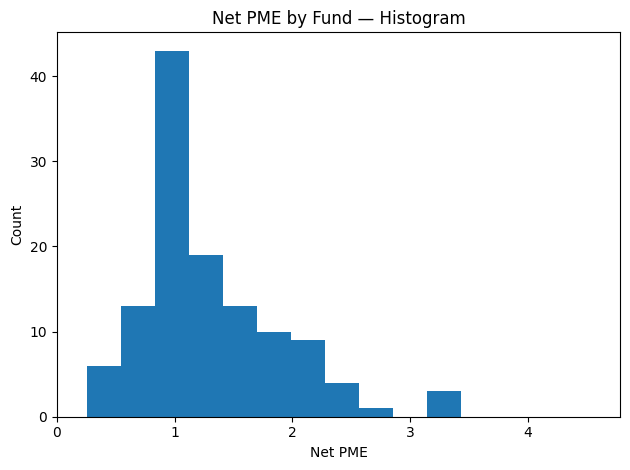

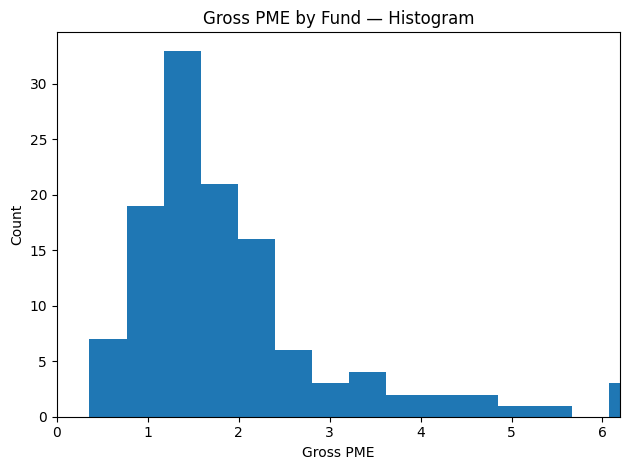

<Figure size 640x480 with 0 Axes>

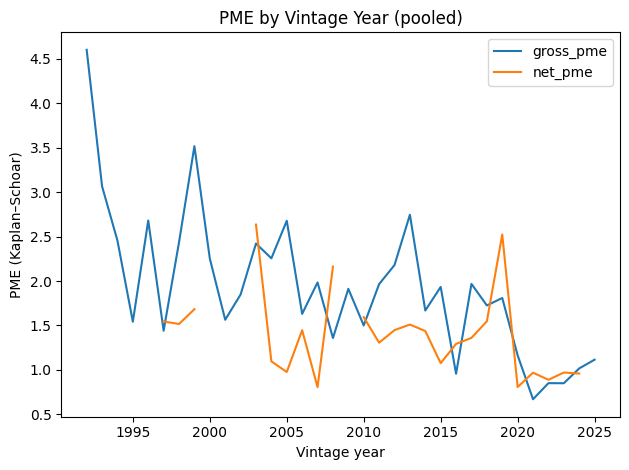


[EXPORT] Wrote:
 - pme_by_vintage.csv
 - per_fund_net_pme.csv
 - per_fund_gross_vs_net_pme.csv


In [242]:
# ======= Per Fund analytics =========

from pathlib import Path
import pandas as pd
import numpy as np

# ---------- Inputs ----------
def find_upwards(rel_path: Path, max_up: int = 8) -> Path:
    here = Path.cwd()
    for parent in [here, *here.parents][: max_up + 1]:
        candidate = (parent / rel_path)
        if candidate.exists():
            return candidate.resolve()
    raise FileNotFoundError(f"Couldn't locate '{rel_path.as_posix()}' from {here} by walking up {max_up} levels.")

DATA_DIR = find_upwards(Path("GrossToNet/Data"))
DEALS_CSV = DATA_DIR / "deal_cash_flow.csv"
FUNDS_CSV = DATA_DIR / "fund_cash_flow.csv"
MAP_CSV   = DATA_DIR / "deal_to_fund.csv"

# ---------- Load data ----------
deals = pd.read_csv(DEALS_CSV, parse_dates=["date"])
funds = pd.read_csv(FUNDS_CSV, parse_dates=["date"])
deal_to_fund = pd.read_csv(MAP_CSV, dtype={"deal_id":str, "fund_id":str})

# ---------- Hard guards ----------
for name, df in [("deals", deals), ("funds", funds)]:
    assert "amount_usd" in df.columns, f"{name}: missing amount_usd; run FX step."
    assert np.isfinite(pd.to_numeric(df["amount_usd"], errors="coerce")).all(), f"{name}: non-finite amount_usd."

# Prefer canonical types if present; else normalize lowercase
def _type_col(df: pd.DataFrame) -> str:
    if "type_std" in df.columns: return "type_std"
    df = df  # not mutating here; handled below when needed
    return "cash_flow_type"

# ---------- Load benchmark ----------
comp = load_composite_usd_series()  # from prior script

# ---------- Prepare typed copies ----------
# Deals: investment (−), proceed (+), fair_value (+)
d = deals.copy()
tcol_d = _type_col(d)
if tcol_d == "cash_flow_type":
    d[tcol_d] = d[tcol_d].astype(str).str.strip().str.lower()

# Funds: contribution (−), distribution (+), nav (+)
f = funds.copy()
tcol_f = _type_col(f)
if tcol_f == "cash_flow_type":
    f[tcol_f] = f[tcol_f].astype(str).str.strip().str.lower()

# ---------- Map deals to funds ----------
# Assumption given: every deal_id and fund_id has a mapping pair (one-to-one per deal)
d = d.merge(deal_to_fund, on="deal_id", how="left", validate="m:1")
assert d["fund_id"].notna().all(), "Unmapped deals after join."

# ---------- Per-fund PME computations ----------
keep_gross = {"investment", "proceed", "fair_value"}
keep_net   = {"contribution", "distribution", "nav"}

# groupby apply with ks_pme_ratio
def _pme_for_group(cf: pd.DataFrame, amount_col: str, date_col: str="date") -> float:
    # ks_pme_ratio handles same-day collapse and tail clipping internally
    return ks_pme_ratio(cf[[date_col, amount_col]], comp, amount_col=amount_col, date_col=date_col)

# Gross PME per fund (from mapped deals)
gross_by_fund = (
    d.loc[d[tcol_d].isin(keep_gross), ["fund_id","date","amount_usd"]]
     .groupby("fund_id", dropna=False, sort=False)
     .apply(lambda g: _pme_for_group(g, "amount_usd"))
     .rename("gross_pme_fund")
)

# Net PME per fund (from fund cash flows)
net_by_fund = (
    f.loc[f[tcol_f].isin(keep_net), ["fund_id","date","amount_usd"]]
     .groupby("fund_id", dropna=False, sort=False)
     .apply(lambda g: _pme_for_group(g, "amount_usd"))
     .rename("net_pme_fund")
)

# ---------- Assemble, report quartiles ----------
per_fund = pd.concat([gross_by_fund, net_by_fund], axis=1)

# Drop NaNs for quartile calc, but keep counts for diagnostics
g_valid = per_fund["gross_pme_fund"].dropna()
n_valid = per_fund["net_pme_fund"].dropna()

def _q(s: pd.Series):
    return {
        "count": int(s.notna().sum()),
        "p25":  float(s.quantile(0.25)) if s.notna().sum() else np.nan,
        "median": float(s.median())     if s.notna().sum() else np.nan,
        "p75":  float(s.quantile(0.75)) if s.notna().sum() else np.nan,
    }

gross_stats = _q(g_valid)
net_stats   = _q(n_valid)

print("=== Per-Fund PME (based on mapping) ===")
print(f"Funds with gross PME: {gross_stats['count']} | p25={gross_stats['p25']:.3f}  "
      f"median={gross_stats['median']:.3f}  p75={gross_stats['p75']:.3f}")
print(f"Funds with net   PME: {net_stats['count']} | p25={net_stats['p25']:.3f}  "
      f"median={net_stats['median']:.3f}  p75={net_stats['p75']:.3f}")

# Optional: compute and store GP “cut” per fund (gross − net)
per_fund["gp_cut_delta_pme"] = per_fund["gross_pme_fund"] - per_fund["net_pme_fund"]


# ===================== PME SENSITIVITY + VISUALS (revised) =====================
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Assumes the new PME engine is imported in the session:
#   load_composite_usd_series, ks_pme_ratio, ks_pme_all_funds,
#   vintage_pme_deals, vintage_pme_funds, pme_components, find_upwards

# -------------------- Setup / guards --------------------
DATA_DIR = find_upwards(Path("GrossToNet/Data"))
comp = load_composite_usd_series()

# Reload USD-enriched CFs (ensures we see amount_usd produced upstream)
deals = pd.read_csv(DATA_DIR / "deal_cash_flow.csv", parse_dates=["date"])
funds = pd.read_csv(DATA_DIR / "fund_cash_flow.csv", parse_dates=["date"])

for name, df in [("deals", deals), ("funds", funds)]:
    assert "amount_usd" in df.columns, f"{name}: missing amount_usd; run FX step."
    assert np.isfinite(pd.to_numeric(df["amount_usd"], errors="coerce")).all(), f"{name}: non-finite amount_usd."

# Column for types (prefer canonical)
def _type_col(df: pd.DataFrame) -> str:
    if "type_std" in df.columns: return "type_std"
    c = "cash_flow_type"
    df[c] = df[c].astype(str).str.strip().str.lower()
    return c

tcol_d = _type_col(deals)
tcol_f = _type_col(funds)

# -------------------- 1) Baseline pooled PMEs --------------------
keep_gross = {"investment","proceed","fair_value"}
keep_net   = {"contribution","distribution","nav"}

gross_pme = ks_pme_ratio(
    deals.loc[deals[tcol_d].isin(keep_gross), ["date","amount_usd"]],
    comp, amount_col="amount_usd", date_col="date"
)
net_pme = ks_pme_ratio(
    funds.loc[funds[tcol_f].isin(keep_net), ["date","amount_usd"]],
    comp, amount_col="amount_usd", date_col="date"
)
fee_drag_delta = gross_pme - net_pme
fee_drag_ratio = (net_pme / gross_pme) if (np.isfinite(gross_pme) and gross_pme > 0) else np.nan

g_num, g_den = pme_components(
    deals.loc[deals[tcol_d].isin(keep_gross), ["date","amount_usd"]],
    comp, amount_col="amount_usd", date_col="date"
)
n_num, n_den = pme_components(
    funds.loc[funds[tcol_f].isin(keep_net), ["date","amount_usd"]],
    comp, amount_col="amount_usd", date_col="date"
)

print("=== POOLED PME (Baseline; incl. NAV/FV) ===")
print(f"GROSS PME (deals) : {gross_pme:0.4f} | Σdist/I={g_num:,.3f}  Σcontrib/I={g_den:,.3f}")
print(f"NET   PME (funds) : {net_pme:0.4f} | Σdist/I={n_num:,.3f}  Σcontrib/I={n_den:,.3f}")
if np.isfinite(fee_drag_ratio):
    print(f"FEE DRAG Δ (gross - net): {fee_drag_delta:0.4f} | ratio (net/gross): {fee_drag_ratio:0.4f}")
else:
    print(f"FEE DRAG Δ (gross - net): {fee_drag_delta:0.4f} | ratio (net/gross): undefined")

# -------------------- 2) Sensitivity: realized-only --------------------
deals_real = deals.loc[deals[tcol_d].isin({"investment","proceed"}), ["date","amount_usd"]]
funds_real = funds.loc[funds[tcol_f].isin({"contribution","distribution"}), ["date","amount_usd"]]

gross_pme_realized = ks_pme_ratio(deals_real, comp, amount_col="amount_usd", date_col="date")
net_pme_realized   = ks_pme_ratio(funds_real, comp, amount_col="amount_usd", date_col="date")
g_num_r, g_den_r   = pme_components(deals_real, comp, amount_col="amount_usd", date_col="date")
n_num_r, n_den_r   = pme_components(funds_real, comp, amount_col="amount_usd", date_col="date")

print("\n=== Sensitivity: REALIZED ONLY (exclude NAV/FV) ===")
print(f"GROSS PME (realized): {gross_pme_realized:0.4f} | Σdist/I={g_num_r:,.3f}  Σcontrib/I={g_den_r:,.3f}  Δ vs baseline={gross_pme_realized-gross_pme:+0.4f}")
print(f"NET   PME (realized): {net_pme_realized:0.4f} | Σdist/I={n_num_r:,.3f}  Σcontrib/I={n_den_r:,.3f}  Δ vs baseline={net_pme_realized-net_pme:+0.4f}")

# -------------------- 3) Per-fund PMEs --------------------
# Net by fund (incl. NAV)
net_by_fund = ks_pme_all_funds(funds, comp, include_nav=True, date_col="date").rename("net_pme")

# Gross by fund via mapping
MAP_CSV = DATA_DIR / "deal_to_fund.csv"
gross_by_fund = None
if MAP_CSV.exists():
    map_df = pd.read_csv(MAP_CSV, dtype={"deal_id": str, "fund_id": str})
    # Filter mapped deals to (inv, proceed, FV) and compute fund-wise PME via engine
    deals_mapped = (deals.merge(map_df, on="deal_id", how="inner")
                         .loc[lambda x: x[tcol_d].isin(keep_gross)])
    gross_by_fund = (deals_mapped
                     .groupby("fund_id", dropna=False)[["date","amount_usd"]]
                     .apply(lambda g: ks_pme_ratio(g, comp, amount_col="amount_usd", date_col="date"))
                     .rename("gross_pme"))
else:
    print("[INFO] deal_to_fund.csv not found — skipping gross-by-fund.")

# -------------------- 4) Vintage PMEs (static, pooled) --------------------
gross_by_vintage = vintage_pme_deals(deals, comp, include_fair_value=True, date_col="date").rename("gross_pme")
net_by_vintage   = vintage_pme_funds(funds, comp, include_nav=True, date_col="date").rename("net_pme")

vint_index = sorted(set(gross_by_vintage.index).union(set(net_by_vintage.index)))
vintage_df = pd.DataFrame({
    "gross_pme": gross_by_vintage.reindex(vint_index),
    "net_pme":   net_by_vintage.reindex(vint_index),
})

# -------------------- 5) Visuals --------------------
# (A) Histogram: Net PME by fund
plt.figure()
vals = net_by_fund.dropna().values
plt.hist(vals, bins="auto")
p99 = np.nanpercentile(vals, 99) if vals.size else np.nan
if np.isfinite(p99): plt.xlim(left=min(vals.min(), 0), right=p99)
plt.title("Net PME by Fund — Histogram")
plt.xlabel("Net PME"); plt.ylabel("Count"); plt.tight_layout(); plt.show()

# (B) Histogram: Gross PME by fund (if mapping available)
if isinstance(gross_by_fund, pd.Series) and not gross_by_fund.dropna().empty:
    plt.figure()
    gvals = gross_by_fund.dropna().values
    plt.hist(gvals, bins="auto")
    p99g = np.nanpercentile(gvals, 99) if gvals.size else np.nan
    if np.isfinite(p99g): plt.xlim(left=min(gvals.min(), 0), right=p99g)
    plt.title("Gross PME by Fund — Histogram")
    plt.xlabel("Gross PME"); plt.ylabel("Count"); plt.tight_layout(); plt.show()
else:
    print("[VIS] Gross PME by fund histogram skipped (no mapping or empty).")

# (C) Vintage chart: static PME by vintage (two lines)
plt.figure()
ax = vintage_df.sort_index().plot(y=["gross_pme","net_pme"])
ax.set_title("PME by Vintage Year (pooled)")
ax.set_xlabel("Vintage year"); ax.set_ylabel("PME (Kaplan–Schoar)")
plt.tight_layout(); plt.show()

# -------------------- 6) Exports --------------------
(vintage_df.reset_index(names="vintage")
          .to_csv(DATA_DIR / "pme_by_vintage.csv", index=False))
net_by_fund.rename_axis("fund_id").reset_index().to_csv(DATA_DIR / "per_fund_net_pme.csv", index=False)
if isinstance(gross_by_fund, pd.Series) and not gross_by_fund.dropna().empty:
    (pd.concat([gross_by_fund, net_by_fund], axis=1)
       .rename_axis("fund_id").reset_index()
       .to_csv(DATA_DIR / "per_fund_gross_vs_net_pme.csv", index=False))

print("\n[EXPORT] Wrote:")
print(" - pme_by_vintage.csv")
print(" - per_fund_net_pme.csv")
if isinstance(gross_by_fund, pd.Series) and not gross_by_fund.dropna().empty:
    print(" - per_fund_gross_vs_net_pme.csv")


[FILTER] kept 95 funds; excluded 53 outliers/undersized.

[Gross PME (per-fund, equal-weight)] n=95  mean=1.926  median=1.590  p25=1.186  p75=2.300

[Net PME (per-fund, equal-weight)] n=95  mean=1.446  median=1.233  p25=0.931  p75=1.779

[Fee drag = gross - net (equal-weight)] n=95  mean=0.481  median=0.248  p25=0.089  p75=0.733

[Fee drag ratio = net/gross (equal-weight)] n=95  mean=0.848  median=0.841  p25=0.644  p75=0.946

[Gross PME (contribution-weighted)] n=95  mean=1.926  median=1.590  p25=1.186  p75=2.300  w-mean=1.868

[Net PME (contribution-weighted)] n=95  mean=1.446  median=1.233  p25=0.931  p75=1.779  w-mean=1.546

[Fee drag (contribution-weighted)] n=95  mean=0.481  median=0.248  p25=0.089  p75=0.733  w-mean=0.322

[Fee drag ratio (contribution-weighted)] n=95  mean=0.848  median=0.841  p25=0.644  p75=0.946  w-mean=0.875

=== Quartiles by Net PME ===
Q1 (low): mean gross=1.213  mean net=0.729  mean drag=0.484  mean net/gross=0.771  (n=24)
Q2: mean gross=1.351  mean net=1.

/var/folders/qd/xj9tr7rx0hg2pt0j07wqkvcc0000gn/T/ipykernel_5102/366512853.py:142: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for lab, g in pfq.groupby("quartile"):
/var/folders/qd/xj9tr7rx0hg2pt0j07wqkvcc0000gn/T/ipykernel_5102/366512853.py:242: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for label, g in pfq.groupby("quartile"):


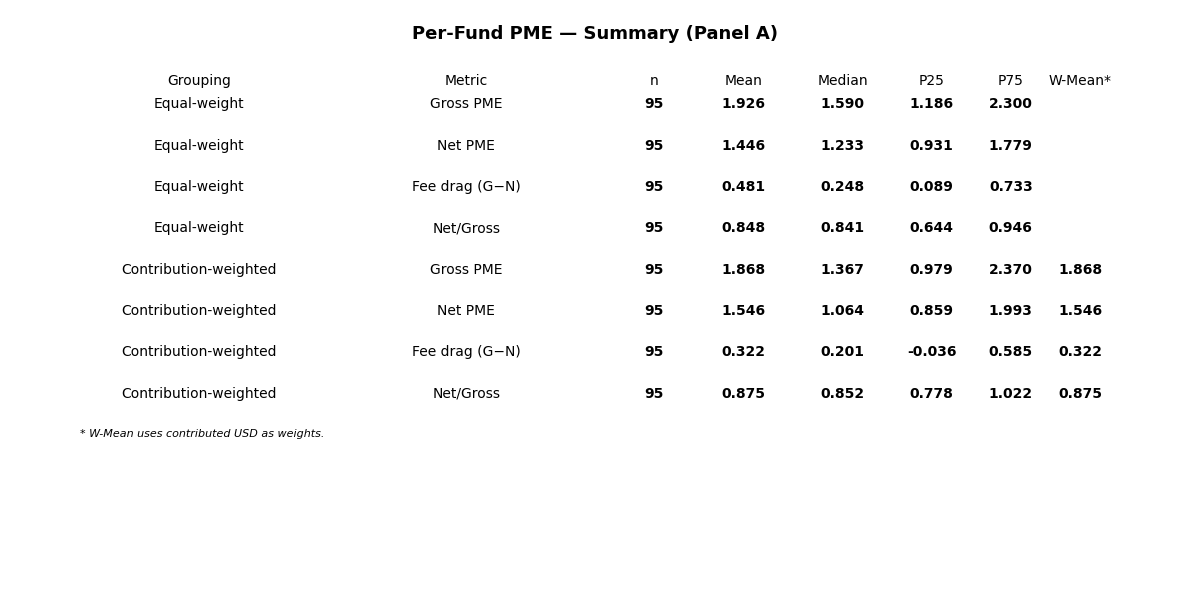

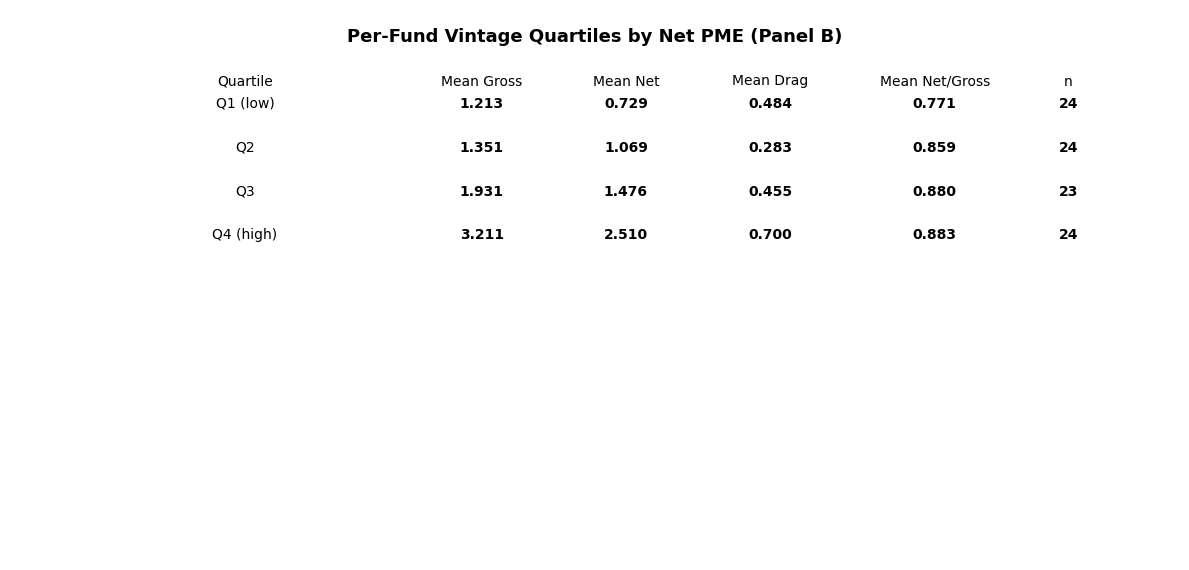

In [244]:
# ===================== PER-FUND GROSS/NET PME & SUMMARIES =====================
from pathlib import Path
import pandas as pd
import numpy as np

DATA_DIR = Path(find_upwards(Path("GrossToNet/Data")))
comp = load_composite_usd_series()

def _amt_col(df): return "amount_usd" if "amount_usd" in df.columns else "amount"

# ------- 1) Per-fund NET PME (incl. NAV) -------
def per_fund_net_pme(funds_df, index_series):
    tcol = "type_std" if "type_std" in funds_df.columns else "cash_flow_type"
    f = funds_df.copy()
    f[tcol] = f[tcol].astype(str).str.strip().str.lower()
    if "date" not in f.columns and "cash_flow_date" in f.columns:
        f = f.rename(columns={"cash_flow_date": "date"})
    keep = {"contribution","distribution","nav"}
    a = _amt_col(f)
    out = {}
    for fid, g in f[f[tcol].isin(keep)].groupby("fund_id", dropna=False):
        cf = g[["date", a]].dropna()
        if cf.empty:
            out[fid] = np.nan
            continue
        cf = aggregate_same_day(cf, "date", a)
        cf = clip_to_index_end(cf, index_series, "date", a)
        out[fid] = ks_pme_ratio(cf, index_series, amount_col=a, date_col="date")
    return pd.Series(out, name="net_pme")

# ------- 2) Per-fund GROSS PME from mapped deals (incl. FAIR_VALUE) -------
def per_fund_gross_pme(deals_df, map_path, index_series):
    if not Path(map_path).exists():
        raise FileNotFoundError("deal_to_fund.csv not found — required for per-fund gross PME.")
    m = pd.read_csv(map_path, dtype={"deal_id":str,"fund_id":str})
    d = deals_df.merge(m, on="deal_id", how="inner")
    tcol = "type_std" if "type_std" in d.columns else "cash_flow_type"
    d[tcol] = d[tcol].astype(str).str.strip().str.lower()
    if "date" not in d.columns and "cash_flow_date" in d.columns:
        d = d.rename(columns={"cash_flow_date":"date"})
    keep = {"investment","proceed","fair_value"}
    d = d[d[tcol].isin(keep)]
    a = _amt_col(d)
    out = {}
    for fid, g in d.groupby("fund_id", dropna=False):
        cf = g[["date", a]].dropna()
        if cf.empty:
            out[fid] = np.nan
            continue
        cf = aggregate_same_day(cf, "date", a)
        cf = clip_to_index_end(cf, index_series, "date", a)
        out[fid] = ks_pme_ratio(cf, index_series, amount_col=a, date_col="date")
    return pd.Series(out, name="gross_pme")

# ------- 3) Compute per-fund series -------
net_s   = per_fund_net_pme(funds, comp)
gross_s = per_fund_gross_pme(deals, DATA_DIR / "deal_to_fund.csv", comp)

per_fund = pd.concat([gross_s, net_s], axis=1)

# ------- 4) Fee drag: level & ratio -------
per_fund["fee_drag"]      = per_fund["gross_pme"] - per_fund["net_pme"]
per_fund["net_over_gross"] = per_fund["net_pme"] / per_fund["gross_pme"]

# ------- 5) Add size anchors (for weighting / filters) -------
#   contributed USD at fund level (absolute sum of contributions)
tcol_f = "type_std" if "type_std" in funds.columns else "cash_flow_type"
a_f    = _amt_col(funds)
f_contrib = (funds.assign(_t=funds[tcol_f].astype(str).str.lower())
                  .loc[lambda x: x["_t"].eq("contribution")]
                  .groupby("fund_id")[a_f].sum().abs()
             .rename("contrib_usd"))

#   invested USD at deal level mapped to funds (absolute sum of investments)
m = pd.read_csv(DATA_DIR / "deal_to_fund.csv", dtype={"deal_id":str,"fund_id":str})
d_map = deals.merge(m, on="deal_id", how="inner")
tcol_d = "type_std" if "type_std" in d_map.columns else "cash_flow_type"
a_d    = _amt_col(d_map)
inv_usd = (d_map.assign(_t=d_map[tcol_d].astype(str).str.lower())
                 .loc[lambda x: x["_t"].eq("investment")]
                 .assign(amt=lambda x: x[a_d].abs())
                 .groupby("fund_id")["amt"].sum()
                 .rename("invested_usd"))

per_fund = per_fund.join(f_contrib, how="left").join(inv_usd, how="left")

# ------- 6) Filters for stability (optional but recommended) -------
PME_MIN, PME_MAX = 0.0, 10.0
MIN_CONTRIB_USD  = 50_000  # set to 0 to disable

mask_valid = (
    per_fund["gross_pme"].between(PME_MIN, PME_MAX) &
    per_fund["net_pme"].between(PME_MIN, PME_MAX)
)
if MIN_CONTRIB_USD > 0:
    mask_valid &= per_fund["contrib_usd"].fillna(0) >= MIN_CONTRIB_USD

pf = per_fund[mask_valid].copy()
excluded = len(per_fund) - len(pf)
print(f"[FILTER] kept {len(pf)} funds; excluded {excluded} outliers/undersized.")

# ------- 7) Cross-sectional summaries across funds -------
def _summarize(s: pd.Series, w: pd.Series | None = None, label=""):
    s0 = s.dropna()
    out = {}
    out["count"]  = s0.count()
    out["mean"]   = float(s0.mean()) if out["count"] else np.nan
    out["median"] = float(s0.median()) if out["count"] else np.nan
    out["p25"]    = float(s0.quantile(0.25)) if out["count"] else np.nan
    out["p75"]    = float(s0.quantile(0.75)) if out["count"] else np.nan
    if w is not None:
        w0 = w.reindex(s0.index).fillna(0)
        if (w0 > 0).any():
            out["weighted_mean"] = float(np.average(s0.values, weights=w0.values))
        else:
            out["weighted_mean"] = np.nan
    print(f"\n[{label}] n={out['count']}  mean={out['mean']:.3f}  median={out['median']:.3f}  "
          f"p25={out['p25']:.3f}  p75={out['p75']:.3f}" +
          (f"  w-mean={out['weighted_mean']:.3f}" if 'weighted_mean' in out else ""))
    return out

# equal-weight across funds (each fund = 1)
gross_eq = _summarize(pf["gross_pme"], label="Gross PME (per-fund, equal-weight)")
net_eq   = _summarize(pf["net_pme"],   label="Net PME (per-fund, equal-weight)")
drag_eq  = _summarize(pf["fee_drag"],  label="Fee drag = gross - net (equal-weight)")
ratio_eq = _summarize(pf["net_over_gross"], label="Fee drag ratio = net/gross (equal-weight)")

# contribution-weighted (proxy for $-weighted LP experience)
gross_w = _summarize(pf["gross_pme"], w=pf["contrib_usd"], label="Gross PME (contribution-weighted)")
net_w   = _summarize(pf["net_pme"],   w=pf["contrib_usd"], label="Net PME (contribution-weighted)")
# for difference and ratio, weighted mean is less canonical; still informative:
drag_w  = _summarize(pf["fee_drag"],  w=pf["contrib_usd"], label="Fee drag (contribution-weighted)")
ratio_w = _summarize(pf["net_over_gross"], w=pf["contrib_usd"], label="Fee drag ratio (contribution-weighted)")

# ------- 8) Quartile summaries (by net PME or gross PME) -------
# choose sorting key; here by net PME
pf = pf.sort_values("net_pme")
q = pd.qcut(pf["net_pme"].rank(method="first"), 4, labels=["Q1 (low)","Q2","Q3","Q4 (high)"])
pfq = pf.join(q.rename("quartile"))

print("\n=== Quartiles by Net PME ===")
for lab, g in pfq.groupby("quartile"):
    m_gross = float(g["gross_pme"].mean())
    m_net   = float(g["net_pme"].mean())
    m_drag  = float(g["fee_drag"].mean())
    m_ratio = float(g["net_over_gross"].mean())
    print(f"{lab}: mean gross={m_gross:.3f}  mean net={m_net:.3f}  "
          f"mean drag={m_drag:.3f}  mean net/gross={m_ratio:.3f}  (n={len(g)})")

# ===================== Table-like figure for per-fund PME summaries =====================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import textwrap

# --- helpers (re-use pf from your per-fund block) ---
def _fmt(x):
    return "" if (x is None or (isinstance(x, float) and (np.isnan(x) or np.isinf(x)))) else f"{x:.3f}"

def _summarize_series(s: pd.Series, w: pd.Series | None = None):
    s0 = s.dropna()
    out = {
        "n": int(s0.count()),
        "mean": float(s0.mean()) if len(s0) else np.nan,
        "median": float(s0.median()) if len(s0) else np.nan,
        "p25": float(s0.quantile(0.25)) if len(s0) else np.nan,
        "p75": float(s0.quantile(0.75)) if len(s0) else np.nan,
        "w_mean": np.nan,
    }
    if w is not None and len(s0):
        w0 = w.reindex(s0.index).fillna(0)
        if (w0 > 0).any():
            out["w_mean"] = float(np.average(s0.values, weights=w0.values))
    return out

# ---------- weighted helpers ----------
import numpy as np
import pandas as pd

def weighted_mean(x: pd.Series, w: pd.Series) -> float:
    x, w = x.dropna(), w.reindex(x.index).fillna(0)
    wpos = w > 0
    if not wpos.any():
        return np.nan
    return float(np.average(x[wpos].values, weights=w[wpos].values))

def weighted_quantile(x: pd.Series, w: pd.Series, qs=(0.25, 0.5, 0.75)):
    """
    Return weighted quantiles for qs in [0,1].
    """
    x, w = x.dropna(), w.reindex(x.index).fillna(0)
    wpos = w > 0
    if not wpos.any():
        return [np.nan for _ in qs]
    xv = x[wpos].values
    wv = w[wpos].values
    order = np.argsort(xv)
    xv, wv = xv[order], wv[order]
    cum_w = np.cumsum(wv)
    total = cum_w[-1]
    if total == 0:
        return [np.nan for _ in qs]
    # positions of quantiles on [0,total]
    targets = np.array(qs) * total
    # interpolate
    return [float(np.interp(t, cum_w, xv)) for t in targets]

def weighted_summary(x: pd.Series, w: pd.Series):
    out = {}
    # equal-weight stats (for reference)
    x0 = x.dropna()
    out["n_eq"]   = int(x0.count())
    out["mean_eq"]= float(x0.mean()) if out["n_eq"] else np.nan
    out["med_eq"] = float(x0.median()) if out["n_eq"] else np.nan
    out["p25_eq"] = float(x0.quantile(0.25)) if out["n_eq"] else np.nan
    out["p75_eq"] = float(x0.quantile(0.75)) if out["n_eq"] else np.nan
    # weighted stats
    out["n_w"]    = int((w.reindex(x.index).fillna(0) > 0).sum())
    out["mean_w"] = weighted_mean(x, w)
    q25, q50, q75 = weighted_quantile(x, w, qs=(0.25, 0.5, 0.75))
    out["p25_w"], out["med_w"], out["p75_w"] = q25, q50, q75
    return out

# --- recompute summaries from pf (so the figure is self-contained) ---
eq_g = _summarize_series(pf["gross_pme"])
eq_n = _summarize_series(pf["net_pme"])
eq_d = _summarize_series(pf["fee_drag"])
eq_r = _summarize_series(pf["net_over_gross"])

w_g  = _summarize_series(pf["gross_pme"], w=pf["contrib_usd"])
w_n  = _summarize_series(pf["net_pme"],   w=pf["contrib_usd"])
w_d  = _summarize_series(pf["fee_drag"],  w=pf["contrib_usd"])
w_r  = _summarize_series(pf["net_over_gross"], w=pf["contrib_usd"])

# --- Panel B: quartiles by Net PME (per-fund) ---
pf_sorted = pf.sort_values("net_pme")
quart = pd.qcut(pf_sorted["net_pme"].rank(method="first"), 4,
                labels=["Q1 (low)", "Q2", "Q3", "Q4 (high)"])
pfq = pf_sorted.join(quart.rename("quartile"))

q_rows = []
for label, g in pfq.groupby("quartile"):
    q_rows.append({
        "Quartile": str(label),
        "mean_gross": float(g["gross_pme"].mean()),
        "mean_net":   float(g["net_pme"].mean()),
        "mean_drag":  float(g["fee_drag"].mean()),
        "mean_ratio": float(g["net_over_gross"].mean()),
        "n":          int(len(g))
    })
qdf = pd.DataFrame(q_rows)

# ===================== FIGURE: Panel A — Per-Fund PME Summary =====================
import numpy as np
import matplotlib.pyplot as plt
import numpy as np

def _fmt(x):
    return "" if (x is None or (isinstance(x, float) and (np.isnan(x) or np.isinf(x)))) else f"{x:.3f}"

def spaced_centers(left, right, widths):
    widths = np.array(widths, dtype=float)
    widths = widths / widths.sum()
    total = right - left
    edges = left + np.cumsum(np.r_[0, widths]) * total
    centers = (edges[:-1] + edges[1:]) / 2.0
    return centers

# Build the rows directly from pf
# Assume pf exists and has columns: gross_pme, net_pme, fee_drag, net_over_gross, contrib_usd

wg = weighted_summary(pf["gross_pme"], pf["contrib_usd"])
wn = weighted_summary(pf["net_pme"],   pf["contrib_usd"])
wd = weighted_summary(pf["fee_drag"],  pf["contrib_usd"])
wr = weighted_summary(pf["net_over_gross"], pf["contrib_usd"])

# Equal-weight rows (unchanged)
rows_A_eq = [
    ("Equal-weight","Gross PME",      f"{wg['n_eq']}",  f"{wg['mean_eq']:.3f}", f"{wg['med_eq']:.3f}", f"{wg['p25_eq']:.3f}", f"{wg['p75_eq']:.3f}", ""),
    ("Equal-weight","Net PME",        f"{wn['n_eq']}",  f"{wn['mean_eq']:.3f}", f"{wn['med_eq']:.3f}", f"{wn['p25_eq']:.3f}", f"{wn['p75_eq']:.3f}", ""),
    ("Equal-weight","Fee drag (G−N)", f"{wd['n_eq']}",  f"{wd['mean_eq']:.3f}", f"{wd['med_eq']:.3f}", f"{wd['p25_eq']:.3f}", f"{wd['p75_eq']:.3f}", ""),
    ("Equal-weight","Net/Gross",      f"{wr['n_eq']}",  f"{wr['mean_eq']:.3f}", f"{wr['med_eq']:.3f}", f"{wr['p25_eq']:.3f}", f"{wr['p75_eq']:.3f}", ""),
]

# Contribution-weighted rows (use weighted stats in all columns + show W-Mean explicitly)
rows_A_w = [
    ("Contribution-weighted","Gross PME",      f"{wg['n_w']}", f"{wg['mean_w']:.3f}", f"{wg['med_w']:.3f}", f"{wg['p25_w']:.3f}", f"{wg['p75_w']:.3f}", f"{wg['mean_w']:.3f}"),
    ("Contribution-weighted","Net PME",        f"{wn['n_w']}", f"{wn['mean_w']:.3f}", f"{wn['med_w']:.3f}", f"{wn['p25_w']:.3f}", f"{wn['p75_w']:.3f}", f"{wn['mean_w']:.3f}"),
    ("Contribution-weighted","Fee drag (G−N)", f"{wd['n_w']}", f"{wd['mean_w']:.3f}", f"{wd['med_w']:.3f}", f"{wd['p25_w']:.3f}", f"{wd['p75_w']:.3f}", f"{wd['mean_w']:.3f}"),
    ("Contribution-weighted","Net/Gross",      f"{wr['n_w']}", f"{wr['mean_w']:.3f}", f"{wr['med_w']:.3f}", f"{wr['p25_w']:.3f}", f"{wr['p75_w']:.3f}", f"{wr['mean_w']:.3f}"),
]

rows_A = rows_A_eq + rows_A_w

fig, ax = plt.subplots(figsize=(12, 6.2))
ax.set_axis_off()

# Layout
ax.text(0.5, 0.96, "Per-Fund PME — Summary (Panel A)", ha="center", va="center",
        fontsize=13, fontweight="bold", transform=ax.transAxes)

left, right = 0.06, 0.94
hdr_y   = 0.88
start_y = 0.84
row_gap = 0.07

# Wider first two columns; then data columns
# order: Grouping | Metric | n | Mean | Median | P25 | P75 | W-Mean*
widths = [0.24, 0.30, 0.08, 0.10, 0.10, 0.08, 0.08, 0.06]
xs = spaced_centers(left, right, widths)

# Headers
for x, t in zip(xs, ["Grouping","Metric","n","Mean","Median","P25","P75","W-Mean*"]):
    ax.text(x, hdr_y, t, ha="center", va="center", fontsize=10, transform=ax.transAxes)

# Rows
y = start_y
for row in rows_A:
    for x, val in zip(xs, row):
        ax.text(x, y, val, ha="center", va="center", fontsize=10,
                fontweight="bold" if x not in xs[:2] else "normal",
                transform=ax.transAxes)
    y -= row_gap

# Footnote
ax.text(left, y+0.01, "* W-Mean uses contributed USD as weights.", ha="left", va="top",
        fontsize=8, style="italic", transform=ax.transAxes)

fig.tight_layout()
# fig.savefig(DATA_DIR / "panel_A_per_fund_summary.png", dpi=200, bbox_inches="tight")
plt.show()

# ===================== FIGURE: Panel B — Per-Fund Vintage Quartiles (by Net PME) =====================
import numpy as np
import matplotlib.pyplot as plt

def _fmt(x):
    return "" if (x is None or (isinstance(x, float) and (np.isnan(x) or np.isinf(x)))) else f"{x:.3f}"

def spaced_centers(left, right, widths):
    widths = np.array(widths, dtype=float)
    widths = widths / widths.sum()
    total = right - left
    edges = left + np.cumsum(np.r_[0, widths]) * total
    centers = (edges[:-1] + edges[1:]) / 2.0
    return centers

# Ensure quartiles appear in order
qdf_sorted = qdf.sort_values("Quartile")

fig, ax = plt.subplots(figsize=(12, 5.8))
ax.set_axis_off()

ax.text(0.5, 0.95, "Per-Fund Vintage Quartiles by Net PME (Panel B)", ha="center", va="center",
        fontsize=13, fontweight="bold", transform=ax.transAxes)

left, right = 0.06, 0.94
hdr_y   = 0.87
start_y = 0.83
row_gap = 0.08

# Wider first column (Quartile)
# order: Quartile | Mean Gross | Mean Net | Mean Drag | Mean Net/Gross | n
widths = [0.32, 0.14, 0.14, 0.14, 0.18, 0.08]
xs = spaced_centers(left, right, widths)

# Headers
for x, t in zip(xs, ["Quartile", "Mean Gross", "Mean Net", "Mean Drag", "Mean Net/Gross", "n"]):
    ax.text(x, hdr_y, t, ha="center", va="center", fontsize=10, transform=ax.transAxes)

# Rows
y = start_y
for _, row in qdf_sorted.iterrows():
    cells = [
        f"{row['Quartile']}",
        _fmt(row["mean_gross"]),
        _fmt(row["mean_net"]),
        _fmt(row["mean_drag"]),
        _fmt(row["mean_ratio"]),
        f"{int(row['n'])}",
    ]
    for x, val in zip(xs, cells):
        ax.text(x, y, val, ha="center", va="center", fontsize=10,
                fontweight="bold" if x != xs[0] else "normal",
                transform=ax.transAxes)
    y -= row_gap

fig.tight_layout()
# fig.savefig(DATA_DIR / "panel_B_per_fund_quartiles.png", dpi=200, bbox_inches="tight")
plt.show()


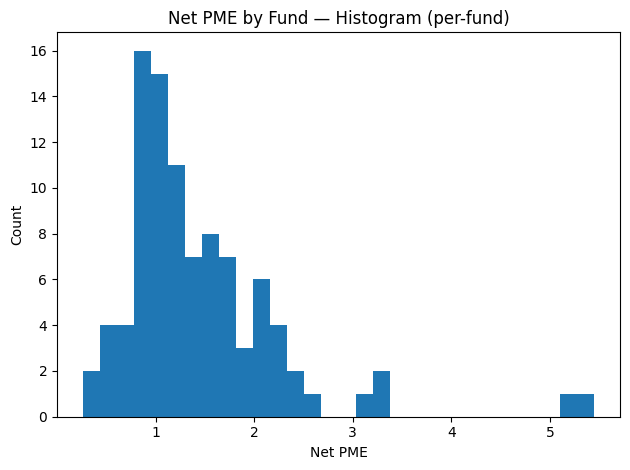

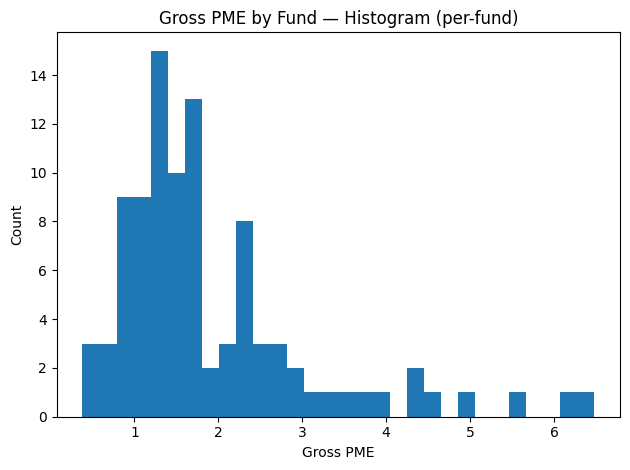

<Figure size 640x480 with 0 Axes>

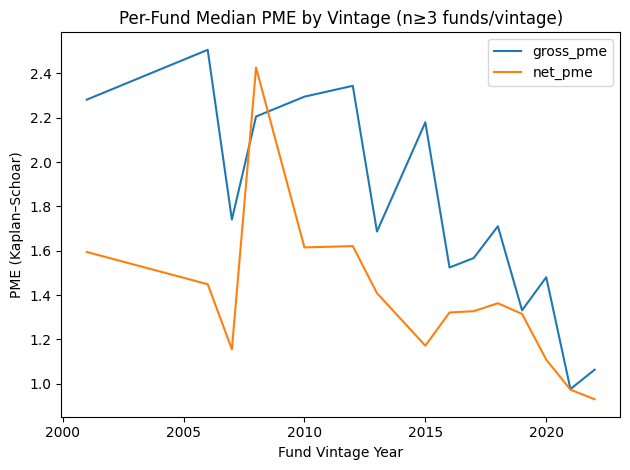

[EXPORT] per_fund_vintage_median_pme.csv


In [245]:
# ===================== PER-FUND VISUALS (Histograms + Vintage Medians) =====================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# If you have pf from the summary block (already filtered to stable funds), reuse it.
# Otherwise build pf by copying per_fund and reapplying your filters:
#   pf = per_fund[
#       per_fund['gross_pme'].between(0.0, 10.0) &
#       per_fund['net_pme'].between(0.0, 10.0) &
#       (per_fund['contrib_usd'].fillna(0) >= 50_000_000)  # optional
#   ].copy()

# --- 1) Histograms: PER-FUND Net PME and PER-FUND Gross PME ---
plt.figure()
plt.hist(pf['net_pme'].dropna().values, bins=30)
plt.title("Net PME by Fund — Histogram (per-fund)")
plt.xlabel("Net PME")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

plt.figure()
plt.hist(pf['gross_pme'].dropna().values, bins=30)
plt.title("Gross PME by Fund — Histogram (per-fund)")
plt.xlabel("Gross PME")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

# --- 2) Per-fund Vintage Medians (Gross & Net) ---
# Fund vintage = year of first contribution for that fund_id
tcol_f = "type_std" if "type_std" in funds.columns else "cash_flow_type"
funds_v = funds.copy()
funds_v[tcol_f] = funds_v[tcol_f].astype(str).str.strip().str.lower()
if "date" not in funds_v.columns and "cash_flow_date" in funds_v.columns:
    funds_v = funds_v.rename(columns={"cash_flow_date": "date"})
fund_vintage = (funds_v[funds_v[tcol_f].eq("contribution")]
                .groupby("fund_id")["date"].min()
                .dt.year.rename("fund_vintage"))

# Join vintage onto filtered per-fund PMEs
pf_v = pf.join(fund_vintage, how="left")

# Require a minimum number of funds per vintage to plot (e.g., >= 5)
min_per_vintage = 3
counts = pf_v.groupby("fund_vintage").size()
valid_vintages = counts[counts >= min_per_vintage].index

medians_by_vintage = (pf_v[pf_v["fund_vintage"].isin(valid_vintages)]
                      .groupby("fund_vintage")[["gross_pme","net_pme"]]
                      .median()
                      .sort_index())

# Line chart of per-fund median PMEs by vintage year
plt.figure()
ax = medians_by_vintage.plot(y=["gross_pme","net_pme"])
ax.set_title(f"Per-Fund Median PME by Vintage (n≥{min_per_vintage} funds/vintage)")
ax.set_xlabel("Fund Vintage Year")
ax.set_ylabel("PME (Kaplan–Schoar)")
plt.tight_layout()
plt.show()

# Optional: export the per-fund vintage medians (+ counts)
vintage_out = medians_by_vintage.join(counts.rename("n_funds"), how="left")
vintage_out.to_csv(DATA_DIR / "per_fund_vintage_median_pme.csv")
print("[EXPORT] per_fund_vintage_median_pme.csv")
